In [1]:
import wandb
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import json
from pathlib import Path
from typing import Dict
from textwrap import wrap

from lmc.logging.plot_utils import *
from lmc.logging import *
from lmc.logging.wandb_utils import get_timeseries_metrics_from_wandb
from importlib import reload
from lmc.utils import Step
import re
import wandb
from lmc.logging.report_utils import mean_std
from lmc.logging.wandb_utils import get_merged_df
from lmc.logging.wandb_registry import WandbMetricsRegistry
import os
from lmc.logging.plot import plot_perturb_barrier
from lmc.logging.plot_utils import TABLE_MAP
from lmc.logging.report_utils import print_to_latex


%load_ext autoreload
%autoreload 2

In [2]:
API_KEY = os.environ.get(
    "GSA_WANDB_API_KEY", "434a41b33878f7e0e1f6f78e317e968d3beb4158"
)
print(API_KEY)
os.environ["WANDB_API_KEY"] = API_KEY
wandb.login(key=API_KEY, relogin=True, force=True)

api = wandb.Api()
api.flush()

434a41b33878f7e0e1f6f78e317e968d3beb4158


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/gsaltintas/.netrc


In [3]:
from lmc.data.data_stats import DatasetRegistry
import math

data_reg = DatasetRegistry


def get_steps(row):
    ts = row["trainer.training_steps"]
    if "ep" not in str(ts):
        return ts
    ts = int(ts[:-2])
    bs = row["data.batch_size"]
    samples = data_reg.get_dataset_info(row["data.dataset"]).samples
    return int(math.ceil(samples / bs) * ts)

/Users/gsaltintas/envs/thesis/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/gsaltintas/envs/thesis/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <9A4710B9-0DA3-36BB-9129-645F282E64B2> /Users/gsaltintas/envs/thesis/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <ECC148AF-20FF-3EEE-BC75-4DD3E7455393> /Users/gsaltintas/envs/thesis/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Dataset qnli_generation not properly set as attribute, doing it now.


## OLMo

In [51]:
project_path = "gsaltintas/LMCPretrainingStability-OLMo"
out= Path("out/butterfly/finetune-rebuttal/olmo")
out.mkdir(exist_ok=True, parents=True)

api.flush()

runs = api.runs(
    project_path,
    filters={
        "tags": {"$nin": ["ignore", "delete", "hidden", "cifar100-wrong-warmup"]},
        # "config.data.dataset": {"$in": ["cifar10", "cifar100"]},
        # "config.n_models": 2,
    },
)
print(len(runs))


122


In [52]:
main_df["model.revision"]

0           step1000-tokens4B
1                        null
2      step369000-tokens1547B
3           step1000-tokens4B
4                        null
                ...          
117         step1000-tokens4B
118                      null
119                      null
120    step369000-tokens1547B
121    step369000-tokens1547B
Name: model.revision, Length: 122, dtype: object

In [59]:
main_df, registry = get_merged_df(
    runs,
    scale_barriers=False,
    performance_aware=False,
    find_missing=False,
    return_registry=True,
)
olmo_revs = {
    "step1000-tokens4B": "Step-1K - 4B Tokens",
    "step369000-tokens1547B": "Step-369K - 1.5T Tokens",
    "null": "Step-740K - 3T Tokens",
    }
main_df["bert_ckpt"] = main_df["model.revision"].apply(lambda x: olmo_revs.get(x))
main_df["trainer.training_steps"] = 5607

na_filters = (
    (main_df["model1.test.accuracy"] != "null")
#     # & (main_df["model1.train.cross_entropy"] != "NaN")
#     & (~main_df["model1.train.cross_entropy"].isna())
#     & (~main_df["model2.train.cross_entropy"].isna())
    & (~main_df[registry.get_metric("lmc_loss_train_0_1").flat_name].isna())
    & (main_df[registry.get_metric("lmc_loss_train_0_1").flat_name] != "null")
#     & (~main_df["bert_ckpt"].isna())
)

merged_df = main_df[na_filters]

merged_df["perturb_step_log"] = merged_df["perturb_step"].apply(np.log)
merged_df["perturb_step_relative"] = merged_df.apply(
    lambda row: row["perturb_step"] / float(row["trainer.training_steps"]) * 100, axis=1
)
# Calculate mean and use pd.concat for efficiency
# average_test_acc = (
#     merged_df[["model1.test.accuracy", "model2.test.accuracy"]].mean(axis=1) * 100
# ).rename("average_test_acc")
# average_train_acc = (
#     merged_df[["model1.train.accuracy", "model2.train.accuracy"]].mean(axis=1) * 100
# ).rename("average_train_acc")
# merged_df = pd.concat([merged_df, average_test_acc, average_train_acc], axis=1)
merged_df.loc[merged_df["perturb_step"] == -1, "perturb_step"] = 0

# )

/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:171: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["trainer.opt.warmup_ratio"].fillna(0, inplace=True)
/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:172: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'null' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.fillna("null", inplace=True)
/var/folders/8n/l2sy_xn

In [ ]:
merged_df["model.revision"].unique()
merged_df["l2.dist_1-2"]

array(['null', 'step369000-tokens1547B', 'step1000-tokens4B'],
      dtype=object)

18
hello l2_dist_1-2 l2_dist_1-2 True
WandbMetric(log_name='l2/dist_1-2', ylabel='$ L2(\\theta_{{1}_t} - \\theta_{{2}_t}) $', prefix='l2_dist_1-2', category=<MetricCategory.L2_DISTANCE: 'l2_distance'>, split=None, general_ylabel='$ L2(\\theta_{{1}_t} - \\theta_{{2}_t}) $', flat_name='l2.dist_1-2') l2.dist_1-2 None
$ L2(\theta_{{1}_t} - \theta_{{2}_t}) $
6 6
Saved figure to out/butterfly/finetune-rebuttal/olmo/olmo-batch-lmc-0-1-loss-weighted-barrier.pdf


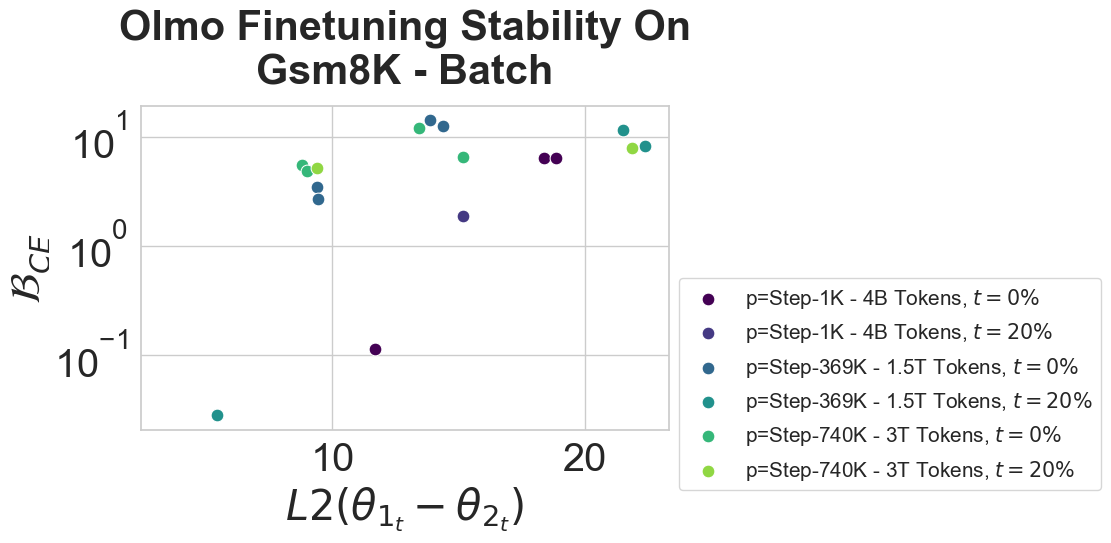

In [102]:
filters_ = (
     ~(merged_df["bert_ckpt"].isna())
    & (merged_df["model2.train.cross_entropy"] < 1)
    & (merged_df["model1.train.cross_entropy"] < 1.5)
    & ((merged_df["perturb_step_relative"] <  9 )
    | (merged_df["perturb_step_relative"] > 12 ))
)

# if True:
perturb_method="batch"
group="olmo"
base_prefix = "lmc"
base_name = f"{base_prefix}_loss_train_0_1"
# base_name = f"{base_prefix}_train_0_1"
# base_name=f"l2_dist_1-2"
zoom = None
x_metric = "perturb_scale"
x_metric = "l2_dist_1-2"
legend_template = r"p={}, $t={:.0f}\%$"
labels = ["bert_ckpt", "perturb_step_relative",  ]

# legend_template = r"$t={:.0f}\%$"
# labels = ["perturb_step_relative",  ]

# for ckpt in merged_df["bert_ckpt"].unique():
if True:
    # filters = (merged_df["bert_ckpt"] == ckpt) & filters_
    filters =filters_
    tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
    print(len(tmp))
    title = (
        f"OLMo Finetuning Stability on GSM8K - {perturb_method}".title()
        # f"OLMo ({ckpt}) Finetuning Stability on GSM8K - {perturb_method}".title()
    )
    t = plot_perturb_barrier(
        tmp,
        registry,
        perturb_method,
        base_name,
        zoom=zoom,
        filter_bad_runs=False,
        separate_legend=True,
        plot_type="scatter",
        title=title,
        x_metric=x_metric,
        labels=labels,
        legend_template=legend_template,
        legend_title="",
        # legend_title="Perturbed At",
        # hue_cnt=6,
        ncols=3,
        save_fig=True,
        # xscale="log",
        save_prefix=group,
        out_dir=out,
        uncertainty=True,
        add_test_line=False,
        style_by="bert_ckpt",
        # palette="tab10",
        yscale="log"
    )

# Cifar Scale


In [214]:
out = Path("out/finetuning/cifar")
out= Path("out/butterfly/finetune-rebuttal")
out.mkdir(exist_ok=True, parents=True)

project_path = "gsaltintas/LMCPretrainingStability"
api.flush()

runs = api.runs(
    project_path,
    filters={
        "tags": {"$nin": ["ignore", "delete", "cifar100-wrong-warmup"]},
        "config.data.dataset": {"$in": ["cifar10", "cifar100"]},
        "config.n_models": 2,
    },
)
print(len(runs))

371


In [215]:
main_df, registry = get_merged_df(
    runs,
    scale_barriers=False,
    performance_aware=False,
    find_missing=False,
    return_registry=True,
)
main_df["bert_ckpt"] = main_df["model.ckpt_path"].apply(lambda x: Path(x).stem)

na_filters = (
    (main_df["model1.test.accuracy"] != "null")
    & (main_df["model1.train.cross_entropy"] != "NaN")
    & (~main_df["model1.train.cross_entropy"].isna())
    & (~main_df["model2.train.cross_entropy"].isna())
    & (~main_df[registry.get_metric("lmc_loss_train_0_1").flat_name].isna())
    & (main_df[registry.get_metric("lmc_loss_train_0_1").flat_name] != "null")
    & (~main_df["bert_ckpt"].isna())
)

merged_df = main_df[na_filters]

merged_df["perturb_step_log"] = merged_df["perturb_step"].apply(np.log)
merged_df["perturb_step_relative"] = merged_df.apply(
    lambda row: row["perturb_step"] / float(row["trainer.training_steps"]) * 100, axis=1
)
# Calculate mean and use pd.concat for efficiency
# average_test_acc = (
#     merged_df[["model1.test.accuracy", "model2.test.accuracy"]].mean(axis=1) * 100
# ).rename("average_test_acc")
# average_train_acc = (
#     merged_df[["model1.train.accuracy", "model2.train.accuracy"]].mean(axis=1) * 100
# ).rename("average_train_acc")
# merged_df = pd.concat([merged_df, average_test_acc, average_train_acc], axis=1)
merged_df.loc[merged_df["perturb_step"] == -1, "perturb_step"] = 0

# )

/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:171: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["trainer.opt.warmup_ratio"].fillna(0, inplace=True)
/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:172: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'null' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.fillna("null", inplace=True)
/var/folders/8n/l2sy_xn

In [216]:
merged_df["trainer.training_steps"].unique()

array([20000])

In [200]:
indices = [
    "run.group",
    "data.dataset",
    "bert_ckpt",
    "model.model_name",
    "trainer.opt.optimizer",
    "trainer.opt.lr",
    "trainer.opt.warmup_ratio",
    "trainer.training_steps",
    "trainer.opt.lr_scheduler",
    "trainer.opt.weight_decay",
    "data.batch_size",
    "dont_perturb_module_patterns",
    "perturb_step",
    "perturb_scale",
    "perturb_mode",
]
pv = merged_df.pivot_table(
    index=indices,
    #                       columns=["model.optimizer", "model.lr"],
    #                        values=['Train', 'Test'],
    values=[
        registry.get_metric("lmc_loss_train_0_1").flat_name,
        "model1.train.cross_entropy",
        # "run.name"
    ],
    # values=['Train', 'Test', "count"],
    aggfunc=["count", mean_std],
    # aggfunc=["count"],
)

pv.to_csv(out.joinpath("pretrain-cifars.csv"))
pv

count  \
                                                                                                                                                                                                                                                                                      lmc-0-1.lmc.loss.weighted.barrier_train   
run.group         data.dataset bert_ckpt model.model_name trainer.opt.optimizer trainer.opt.lr trainer.opt.warmup_ratio trainer.training_steps trainer.opt.lr_scheduler trainer.opt.weight_decay data.batch_size dont_perturb_module_patterns perturb_step perturb_scale perturb_mode                                           
cifar10-resnet50- cifar10      0ep180st  resnet50-64      sgd                   0.1            0.025                    20000                  onecycle                 0.0001                   128             ['.*norm.*|.*bias.*']        1            0.00001       batch                                              1   
                                                                                                                                                                                                                                                           0.00100       batch                                              1   
                                                                                                                                                                                                                                                           0.01000       batch                                              1   
                                                                                                                                                                                                                                                                         gaussian                                           1   
                                                                                                                                                                                                                                                           0.05000       batch                                              1   
...                                                                                                                                                                                                                                                                                                                       ...   
rand-labels       cifar10      3ep327st  resnet50-64      sgd                   0.1            0.025                    20000                  onecycle                 0.0001                   128             ['.*norm.*|.*bias.*']        10000        0.01000       batch                                              1   
                                                                                                                                                                                                                                                           0.05000       batch                                              1   
                               57ep213st resnet50-64      sgd                   0.1            0.025                    20000                  onecycle                 0.0001                   128             ['.*norm.*|.*bias.*']        1            0.00001       batch                                              1   
                                                                                                                                                                                                                                                           0.05000       batch                                              1   
                                                                                                                                           

In [175]:
sum(merged_df["data.random_labels"] == True)

43

## Cifar 100->10 Random Labels

batch
23
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved figure to out/butterfly/finetune-rebuttal/cifar-10-rand-labels-batch-lmc-0-1-loss-weighted-barrier.png


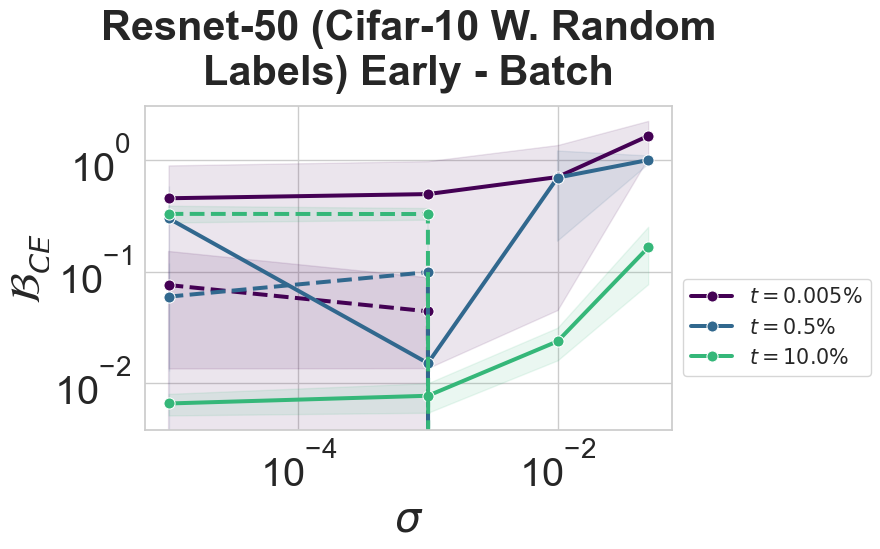

23
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved figure to out/butterfly/finetune-rebuttal/cifar-10-rand-labels-batch-perm-wm-0-1-loss-weighted-barrier.png


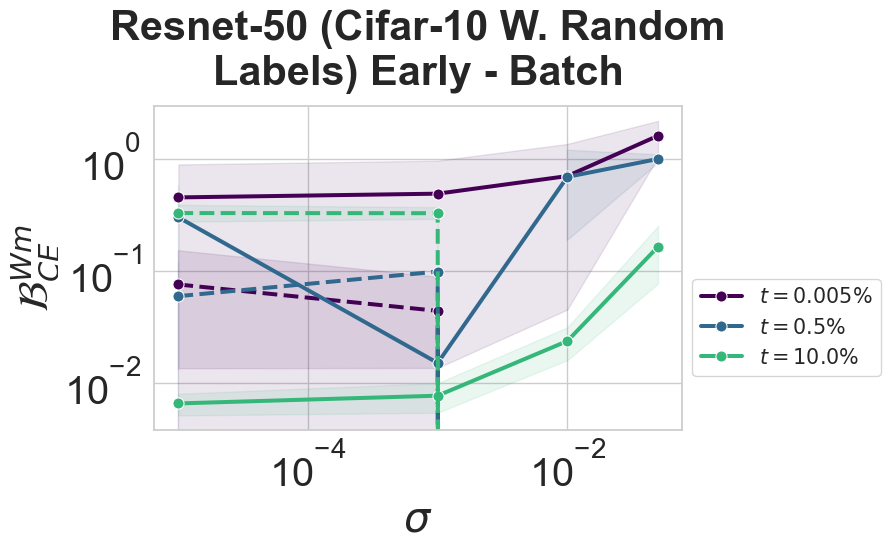

batch
11
hello perturb_scale perturb_scale False
Saved figure to out/butterfly/finetune-rebuttal/cifar-10-rand-labels-batch-lmc-0-1-loss-weighted-barrier.png


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


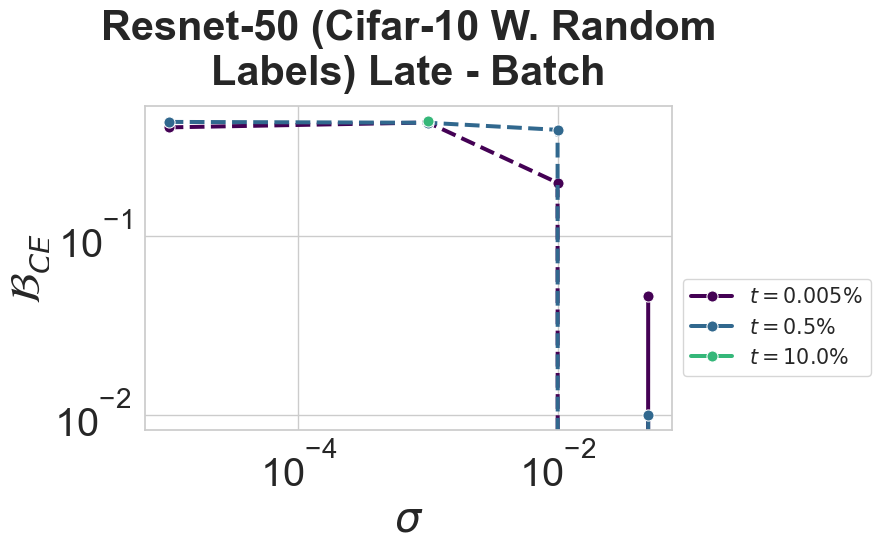

11
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved figure to out/butterfly/finetune-rebuttal/cifar-10-rand-labels-batch-perm-wm-0-1-loss-weighted-barrier.png


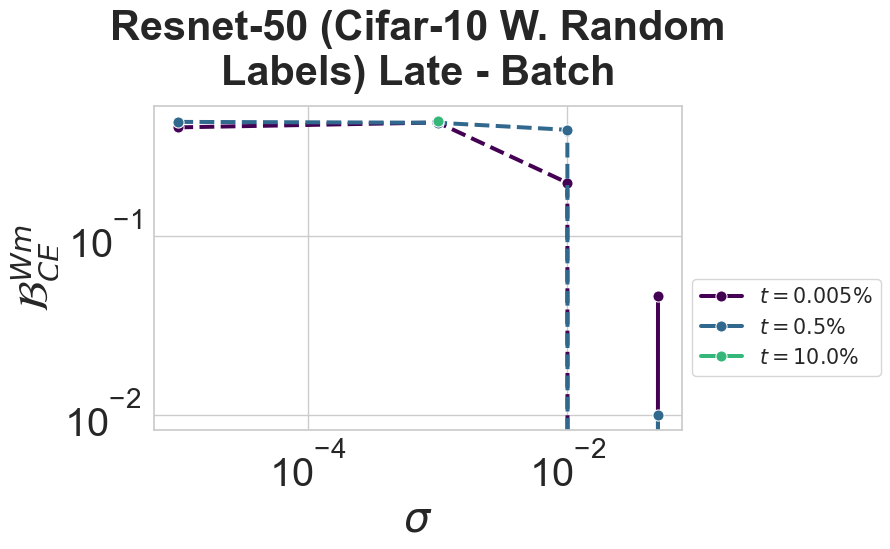

In [59]:
group = "cifar100-to-10-last"
filters = (merged_df["data.dataset"] == "cifar10") & (
    merged_df["bert_ckpt"] == "191ep319st"
)
filters = (merged_df["data.dataset"] == "cifar10") & (
    merged_df["bert_ckpt"] == "57ep213st"
)
filters = (merged_df["data.dataset"] == "cifar10") & (
    merged_df["bert_ckpt"] == "0ep180st"
)
filters = (merged_df["data.dataset"] == "cifar10") & (
    merged_df["bert_ckpt"] == "3ep327st"
)

filters_ = (
    (merged_df["data.random_labels"] == True)
    & (merged_df["run.group"] == "rand-labels")
    # & (merged_df["run.group"] == "cifar10-resnet50-64-random-init")
    & ~(merged_df["bert_ckpt"].isna())
    & (merged_df["perturb_step_relative"] < 50)
    & (merged_df["model2.train.cross_entropy"] < 0.4)
)

ckpt_groups = [
    ("early", ("0ep180st", "3ep327st")),
    ("late", ("57ep213st", "191ep319st")),
]
# if True:
for phase, ckpt_group in ckpt_groups:
    filters = (
        filters_
        & (merged_df["data.dataset"] == "cifar10")
        & merged_df["bert_ckpt"].isin(ckpt_group)
    )
    group = f"cifar-10-rand-labels"
    # for perturb_method in ["batch"]:
    for perturb_method in merged_df[filters]["perturb_mode"].unique():
        print(perturb_method)
        # for base_prefix in ["lmc"]:
        for base_prefix in ["lmc", "perm_wm"]:
            base_name = f"{base_prefix}_loss_train_0_1"
            zoom = None
            x_metric = "perturb_scale"
            legend_template = r"$t={}\%$"
            labels = ["perturb_step_relative",  ]

            tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
            print(len(tmp))
            title = (
                f"ResNet-50 (Cifar-10 w. Random Labels) {phase} - {perturb_method}".title()
            )
            t = plot_perturb_barrier(
                tmp,
                registry,
                perturb_method,
                base_name,
                zoom=zoom,
                filter_bad_runs=False,
                separate_legend=True,
                plot_type="line",
                title=title,
                x_metric=x_metric,
                labels=labels,
                legend_template=legend_template,
                legend_title="",
                # legend_title="Perturbed At",
                # hue_cnt=5,
                ncols=3,
                save_fig=True,
                xscale="log",
                save_prefix=group,
                out_dir=out,
                uncertainty=True,
                add_test_line=True
            )

## Cifar10 - ResNET 50 Random Init


batch
30
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved figure to out/butterfly/finetune-rebuttal/cifar-10-rand-init-batch-lmc-0-1-loss-weighted-barrier.png


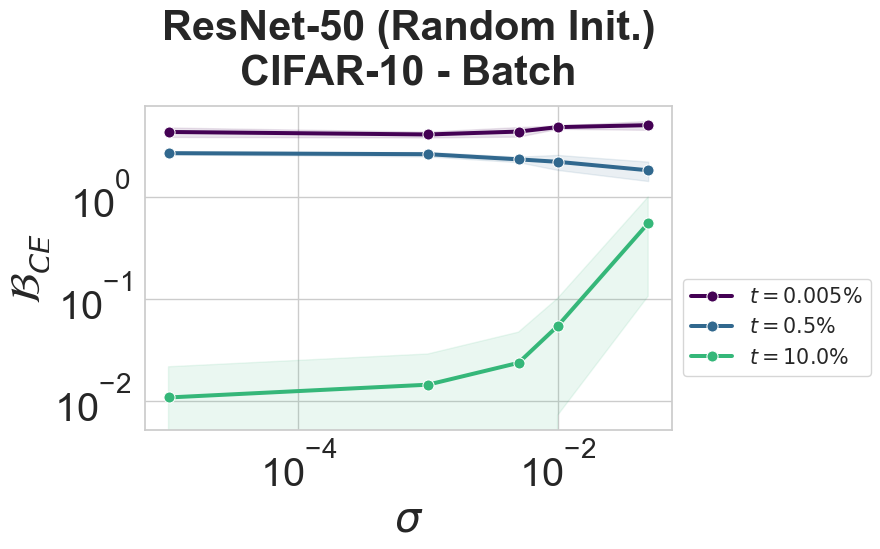

30
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved figure to out/butterfly/finetune-rebuttal/cifar-10-rand-init-batch-perm-wm-0-1-loss-weighted-barrier.png


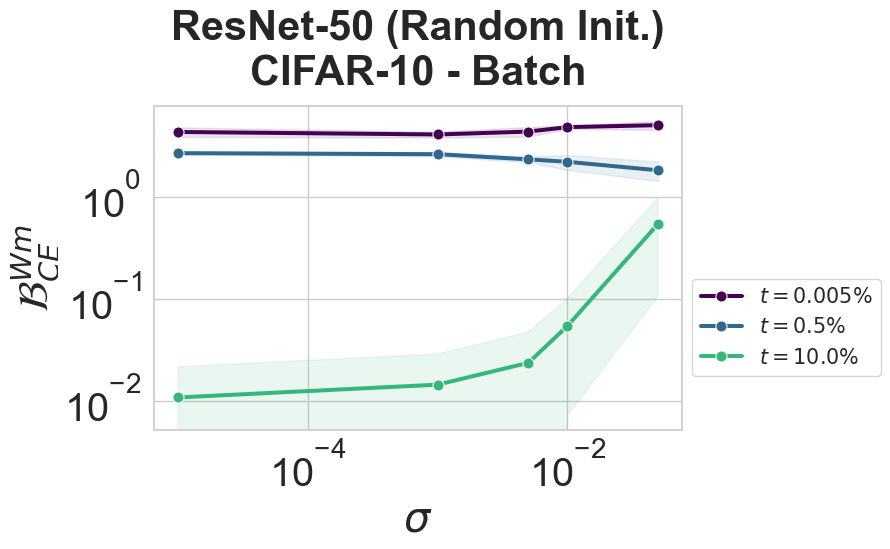

In [60]:
group = "cifar100-to-10-last"
filters = (merged_df["data.dataset"] == "cifar10") & (
    merged_df["bert_ckpt"] == "191ep319st"
)
filters = (merged_df["data.dataset"] == "cifar10") & (
    merged_df["bert_ckpt"] == "57ep213st"
)
filters = (merged_df["data.dataset"] == "cifar10") & (
    merged_df["bert_ckpt"] == "0ep180st"
)
filters = (merged_df["data.dataset"] == "cifar10") & (
    merged_df["bert_ckpt"] == "3ep327st"
)

filters_ = (
    (merged_df["data.random_labels"] != True)
    & (merged_df["run.group"] != "rand-labels")
    & (merged_df["run.group"] == "cifar10-resnet50-64-random-init")
    & ~(merged_df["bert_ckpt"].isna())
    & (merged_df["perturb_step_relative"] < 50)
    & (merged_df["model2.train.cross_entropy"] < 0.4)
)

ckpt_groups = [
    ("early", ("0ep180st", "3ep327st")),
    ("late", ("57ep213st", "191ep319st")),
]
if True:
# for phase, ckpt_group in ckpt_groups:
    filters = (
        filters_
        & (merged_df["data.dataset"] == "cifar10")
        # & merged_df["bert_ckpt"].isin(ckpt_group)
    )
    group = f"cifar-10-rand-init"
    # for perturb_method in ["batch"]:
    for perturb_method in merged_df[filters]["perturb_mode"].unique():
        print(perturb_method)
        # for base_prefix in ["lmc"]:
        for base_prefix in ["lmc", "perm_wm"]:
            base_name = f"{base_prefix}_loss_train_0_1"
            zoom = None
            x_metric = "perturb_scale"
            legend_template = r"$t={}\%$"
            labels = ["perturb_step_relative"]

            tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
            print(len(tmp))
            title = (
                f"ResNet-50 (Random Init.)   CIFAR-10 - {perturb_method.title()}"
            )
            t = plot_perturb_barrier(
                tmp,
                registry,
                perturb_method,
                base_name,
                zoom=zoom,
                filter_bad_runs=False,
                separate_legend=True,
                plot_type="line",
                title=title,
                x_metric=x_metric,
                labels=labels,
                legend_template=legend_template,
                # legend_title="Perturbed At",
                legend_title="",
                # hue_cnt=5,
                ncols=3,
                save_fig=True,
                xscale="log",
                save_prefix=group,
                out_dir=out,
                uncertainty=True,
            )

## Cifar 100 -> Cifar10


batch
33
hello perturb_scale perturb_scale False
perturb_scale perturb_scale None
$\sigma$
Saved figure to out/butterfly/finetune-rebuttal/cifar100-to-10-early-batch-lmc-0-1-loss-weighted-barrier.pdf


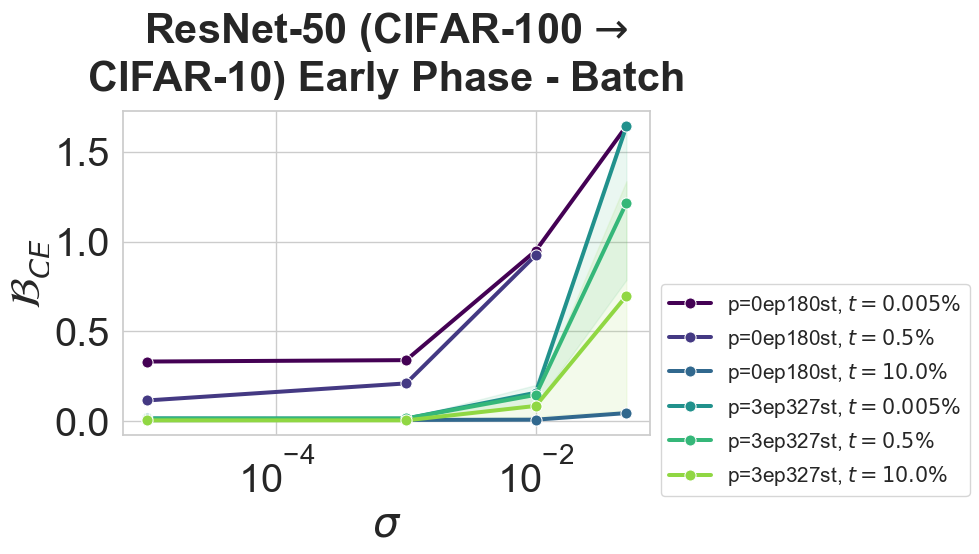

33
hello perturb_scale perturb_scale False
perturb_scale perturb_scale None
$\sigma$
Saved figure to out/butterfly/finetune-rebuttal/cifar100-to-10-early-batch-perm-wm-0-1-loss-weighted-barrier.pdf


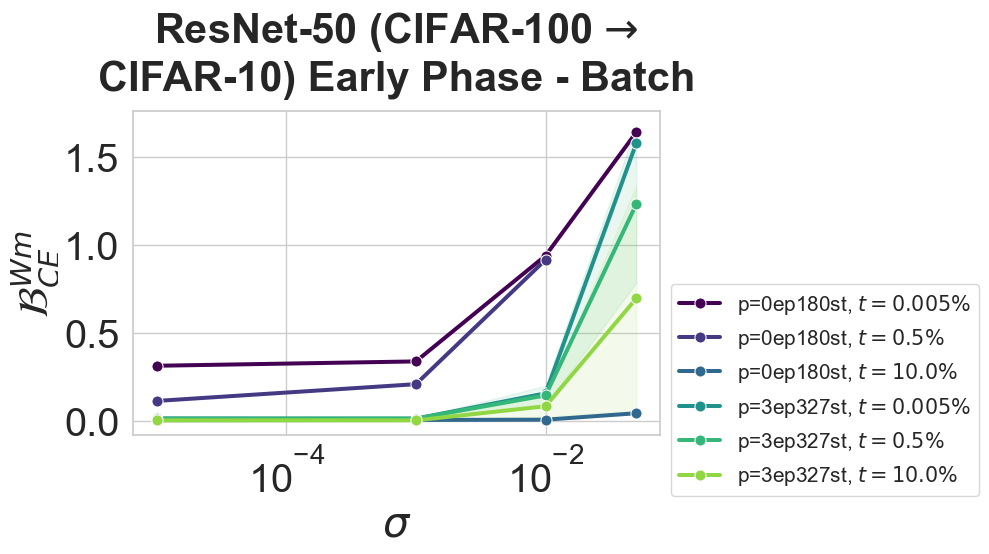

gaussian
14
hello perturb_scale perturb_scale False
perturb_scale perturb_scale None
$\sigma$
Saved figure to out/butterfly/finetune-rebuttal/cifar100-to-10-early-gaussian-lmc-0-1-loss-weighted-barrier.pdf


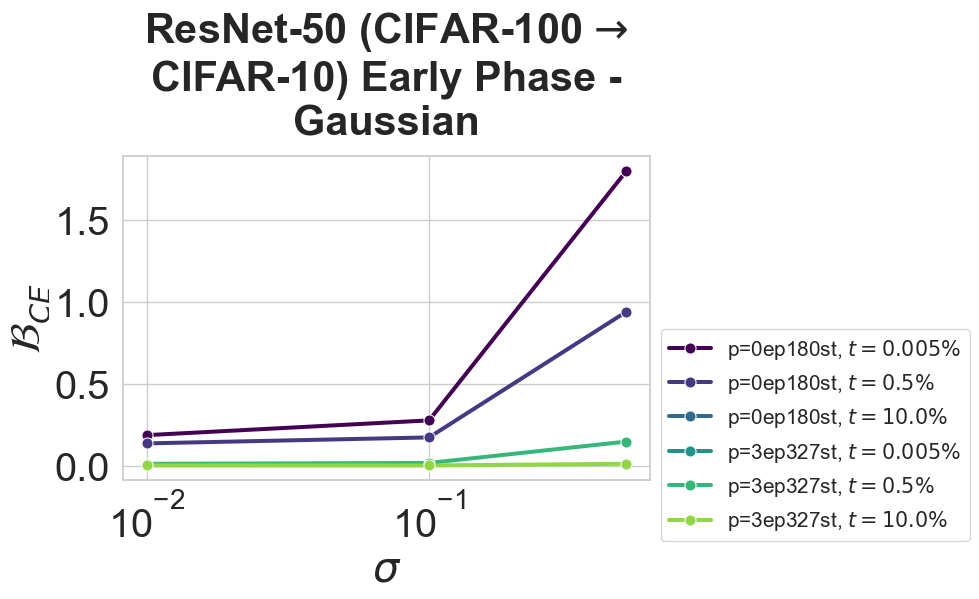

14
hello perturb_scale perturb_scale False
perturb_scale perturb_scale None
$\sigma$
Saved figure to out/butterfly/finetune-rebuttal/cifar100-to-10-early-gaussian-perm-wm-0-1-loss-weighted-barrier.pdf


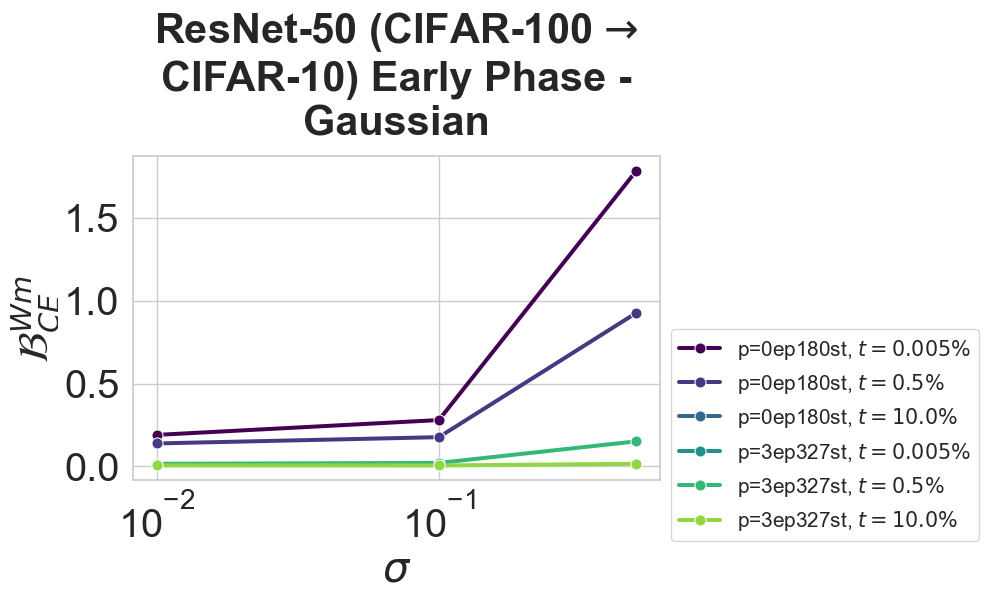

batch
46
hello perturb_scale perturb_scale False
perturb_scale perturb_scale None
$\sigma$
Saved figure to out/butterfly/finetune-rebuttal/cifar100-to-10-late-batch-lmc-0-1-loss-weighted-barrier.pdf


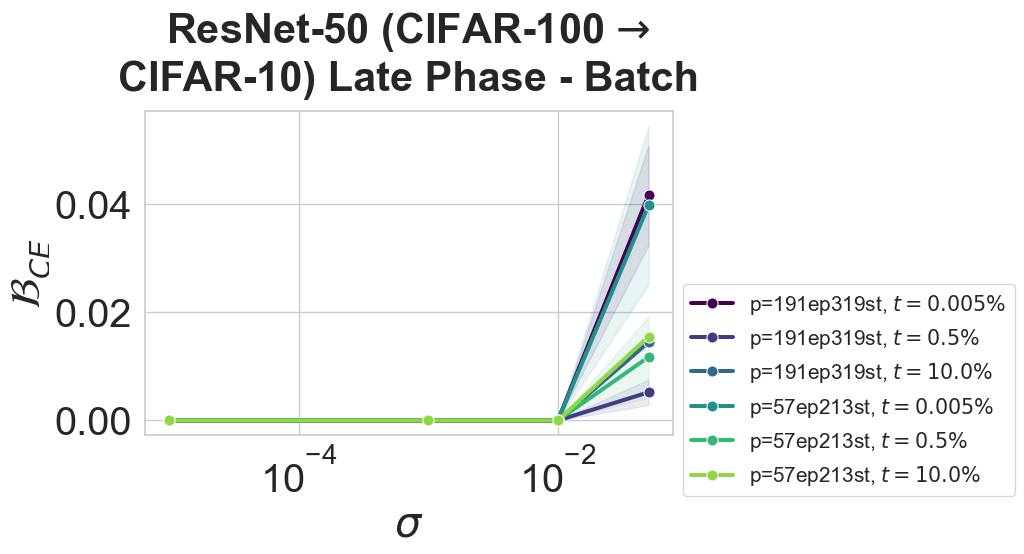

46
hello perturb_scale perturb_scale False
perturb_scale perturb_scale None
$\sigma$
Saved figure to out/butterfly/finetune-rebuttal/cifar100-to-10-late-batch-perm-wm-0-1-loss-weighted-barrier.pdf


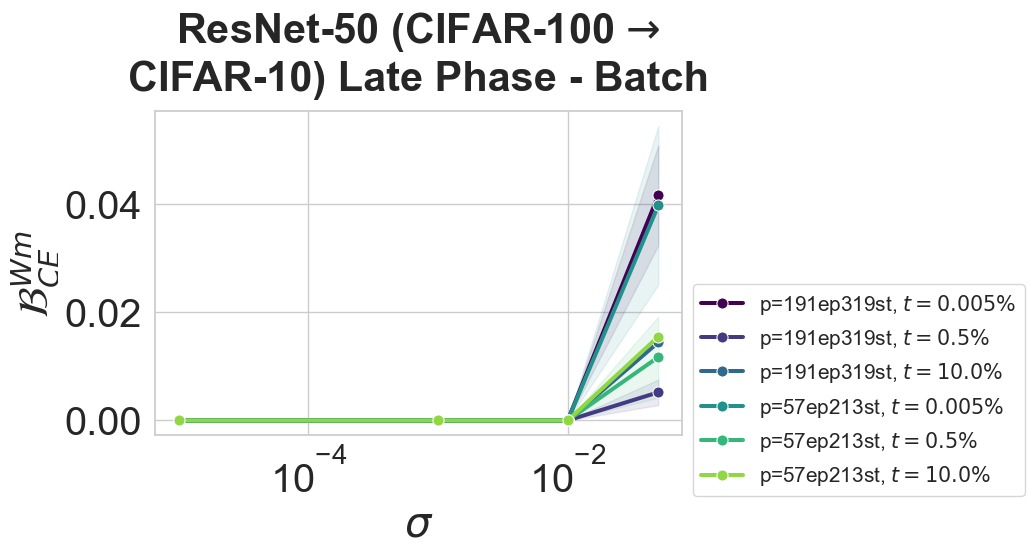

gaussian
18
hello perturb_scale perturb_scale False
perturb_scale perturb_scale None
$\sigma$
Saved figure to out/butterfly/finetune-rebuttal/cifar100-to-10-late-gaussian-lmc-0-1-loss-weighted-barrier.pdf


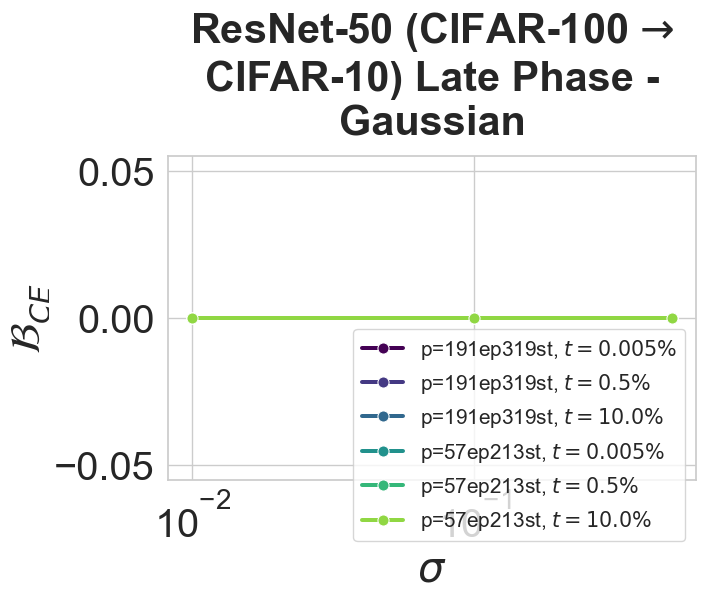

18
hello perturb_scale perturb_scale False
perturb_scale perturb_scale None
$\sigma$
Saved figure to out/butterfly/finetune-rebuttal/cifar100-to-10-late-gaussian-perm-wm-0-1-loss-weighted-barrier.pdf


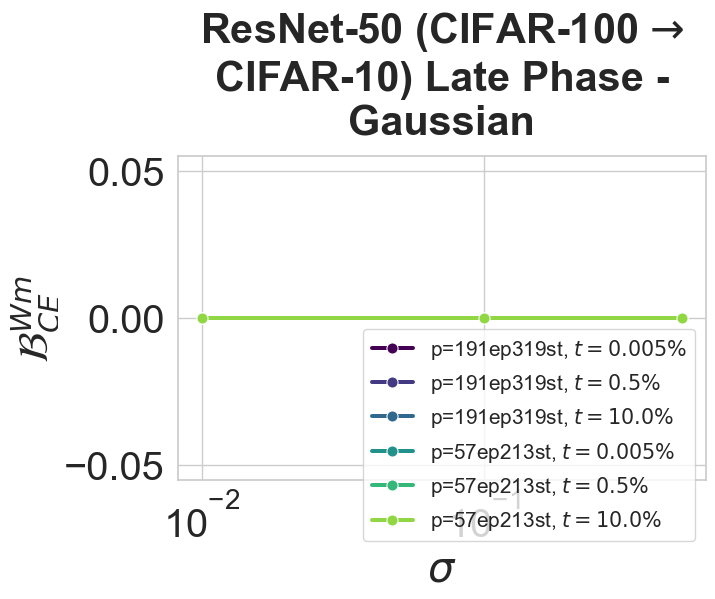

In [113]:
from matplotlib import scale as mscale
from lmc.logging.plot import SafeLogScale

# Register the scale so it can be used in plots
mscale.register_scale(SafeLogScale)


group = "cifar100-to-10-last"
filters = (merged_df["data.dataset"] == "cifar10") & (
    merged_df["bert_ckpt"] == "191ep319st"
)
filters = (merged_df["data.dataset"] == "cifar10") & (
    merged_df["bert_ckpt"] == "57ep213st"
)
filters = (merged_df["data.dataset"] == "cifar10") & (
    merged_df["bert_ckpt"] == "0ep180st"
)
filters = (merged_df["data.dataset"] == "cifar10") & (
    merged_df["bert_ckpt"] == "3ep327st"
)

filters_ = (
    (merged_df["data.random_labels"] != True)
    & (merged_df["run.group"] != "rand-labels")
    & (merged_df["run.group"] == "cifar10-resnet50-")
    & ~(merged_df["bert_ckpt"].isna())
    & (merged_df["model2.train.cross_entropy"] < 0.4)
)

ckpt_groups = [
    ("early", ("0ep180st", "3ep327st")),
    ("late", ("57ep213st", "191ep319st")),
]
for phase, ckpt_group in ckpt_groups:
    filters = (
        filters_
        & (merged_df["data.dataset"] == "cifar10")
        & merged_df["bert_ckpt"].isin(ckpt_group)
    )
    group = f"cifar100-to-10-{phase}"
    # for perturb_method in ["batch"]:
    for perturb_method in merged_df[filters]["perturb_mode"].unique():
        print(perturb_method)
        # for base_prefix in ["lmc"]:
        for base_prefix in ["lmc", "perm_wm"]:
            base_name = f"{base_prefix}_loss_train_0_1"
            zoom = None
            # zoom="first"
            zoom_last_step = 0.01
            x_metric = "perturb_scale"
            legend_template = r"$t={}\%, p={}$"
            labels = ["perturb_step_relative", "bert_ckpt"]
            legend_template = r"p={}, $t={}\%$"
            labels = ["bert_ckpt", "perturb_step_relative"]

            tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
            print(len(tmp))
            title = (
                f"ResNet-50 (CIFAR-100 $\\to$ CIFAR-10)"
                + f" {phase.title()} Phase - {perturb_method.title()}")
            t = plot_perturb_barrier(
                tmp,
                registry,
                perturb_method,
                base_name,
                zoom=zoom,
                # zoom_first_step=zoom_last_step,
                filter_bad_runs=False,
                separate_legend=True,
                plot_type="line",
                title=title,
                x_metric=x_metric,
                labels=labels,
                legend_template=legend_template,
                # legend_title="Perturbed At, Spawning Checkpoint",
                # legend_title="Spawning Checkpoint, Perturbed At",
                legend_title="",
                # hue_cnt=5,
                ncols=3,
                save_fig=True,
                xscale="log",
                save_prefix=group,
                out_dir=out,
                uncertainty=True,
                # yscale='safe_log'
                yscale="linear",
            )

In [90]:
from lmc.logging.report_utils import print_to_markdown

merged_df["bert_ckpt"].unique()
f = (
    (merged_df["bert_ckpt"].isin(['191ep319st', '57ep213st']))
     & (merged_df["data.dataset"] == "cifar10")
     & (~merged_df["run.group"].isin(["rand-labels"]))
     & (merged_df["perturb_scale"] <= 0.01)
    )
merged_df[f][["lmc-0-1.lmc.loss.weighted.barrier_train","l2.dist_1-2" ]]

group_ind = ["data.dataset", "bert_ckpt", "model.model_name", "perturb_step_relative", "perturb_scale"]
groups = merged_df.sort_values("model1.train.cross_entropy", ascending=True)[
    group_ind
].drop_duplicates()
pv = merged_df.pivot_table(
    index=group_ind, values="run_full_path", aggfunc="first"
).reset_index()
print(len(pv))
keys = [
    "lmc-0-1.lmc.loss.weighted.barrier_train",
    "l2.dist_1-2"
    # "model2/train/cross_entropy",
    # "model2/test/cross_entropy",
    # "model2/train/accuracy",
    # "model2/test/accuracy",
    # "model1/train/cross_entropy",
    # "model1/test/cross_entropy",
    # "model1/train/accuracy",
    # "model1/test/accuracy",
]
report_df = merged_df[f][[*keys, *group_ind]]

pv = report_df.sort_values(["perturb_step_relative", "perturb_scale"], ascending=True).pivot_table(
    index=[
        # "data.dataset",
        "bert_ckpt",
        "perturb_step_relative", "perturb_scale"
    ],
    values=keys,
    aggfunc=[mean_std],
)

latex_pv = pv.droplevel(0, axis=1).reset_index()

# latex_pv["data.dataset"] = latex_pv["data.dataset"].apply(lambda x: x.upper())
latex_pv = latex_pv.rename(columns=TABLE_MAP)
print_to_markdown(latex_pv, threshold=1e7, float_precision=5)


173
| Starting Checkpoint   |   perturb_step_relative |   perturb_scale | l2.dist_1-2   | lmc-0-1.lmc.loss.weighted.barrier_train   |
|:----------------------|------------------------:|----------------:|:--------------|:------------------------------------------|
| 191ep319st            |                 0.00500 |         0.00001 | 39.41 ± 0.23  | 0.00 ± 0.00                               |
| 191ep319st            |                 0.00500 |         0.00100 | 39.46 ± 0.18  | 0.00 ± 0.00                               |
| 191ep319st            |                 0.00500 |         0.01000 | 40.41 ± 0.82  | 0.00 ± 0.00                               |
| 191ep319st            |                 0.50000 |         0.00001 | 39.49 ± 0.23  | 0.00 ± 0.00                               |
| 191ep319st            |                 0.50000 |         0.00100 | 39.42 ± 0.19  | 0.00 ± 0.00                               |
| 191ep319st            |                 0.50000 |         0.01000 | 40.03 ± 0.62  | 

/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:284: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_df = df.applymap(format_float)


## Performance

111
hello test_accuracy_2 test_accuracy_2 True
WandbMetric(log_name='model2/test/accuracy', ylabel='$\\mathrm{Acc}^{2}_{\\mathrm{Te}}$', prefix='model2-acc', category=<MetricCategory.ACCURACY: 'accuracy'>, split=<Split.TEST: 'test'>, general_ylabel='$\\mathrm{Acc}^{2}_{\\mathrm{}}$', flat_name='model2.test.accuracy') model2.test.accuracy None
None


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


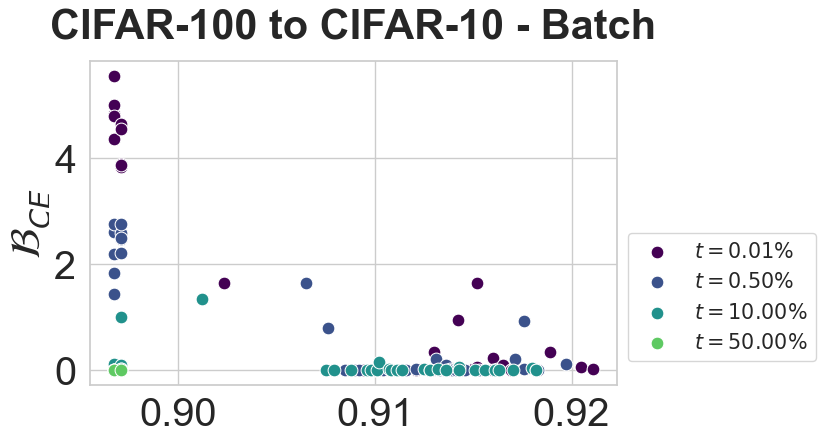

In [177]:
perturb_method = "batch"

group = dataset
dataset = "Cifar10"
filters_ = (
    (merged_df["data.dataset"] == dataset.lower()) 
    # (merged_df["trainer.opt.warmup_ratio"] > 0)
    # & (merged_df["perturb_step"] > 0)
    & (merged_df["model2.train.accuracy"] > 0.9)
    # & (merged_df["model1.train.accuracy"] > 0.9)
    & ~(merged_df["run.group"] == "rand-labels")
    & ~(merged_df["bert_ckpt"].isna())
    # & (merged_df["model2.train.cross_entropy"] < 0.4)
    # & (merged_df["model1.train.cross_entropy"] < 0.4)
)
if True:
# for bert_ckpt in merged_df["bert_ckpt"].unique():
    # for ckpt in merged_df["bert_ckpt"].unique():
    # filters = filters_ & (merged_df["bert_ckpt"] == bert_ckpt)
    filters = filters_
    for base_prefix in ["lmc"]:
    # for base_prefix in ["lmc", "perm_wm"]:
        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "perturb_scale"
        legend_template = r"$t={:.2f}\%$"
        labels = ["perturb_step_relative"]
        # labels = ["bert_ckpt"]
        # labels=["bert_ckpt", "perturb_step_relative"]
        x_metric = f"test_accuracy_2"
        xscale="linear"

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
        print(len(tmp))
        title = f"{bert_ckpt} to {dataset.upper()} - {perturb_method.title()}"
        title = f"CIFAR-100 to CIFAR-10 - {perturb_method.title()}"
        
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=False,
            # separate_legend=True,
            plot_type="scatter",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
        legend_title="",
            # legend_title="Perturbed at",
            # hue_cnt=5,
            ncols=4,
            save_fig=False,
            xscale=xscale,
            yscale="linear",
            out_dir=out,
            uncertainty=True,
            file_extension="png",
            save_prefix=f"vit-{group}"
        )

### Cifar100->10 L2 etc

batch 79
hello l2_dist_1-2 l2_dist_1-2 True


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved figure to out/butterfly/finetune-rebuttal/scatter/l2-barr-group-cifar100-to-10-batch-lmc-0-1-loss-weighted-barrier.png


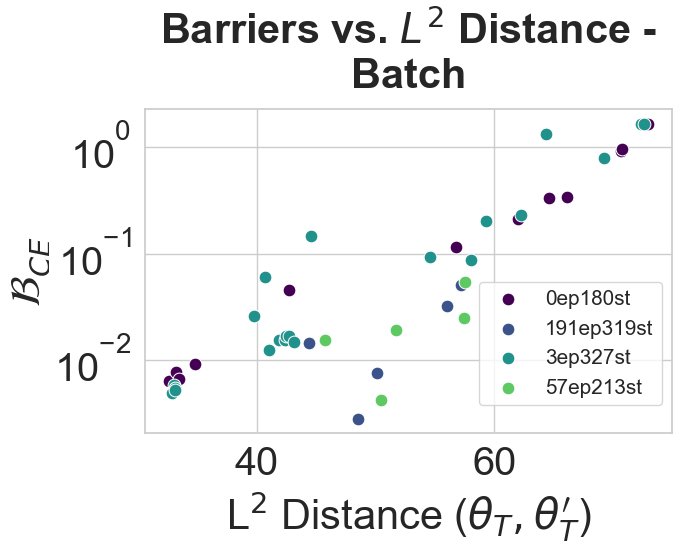

batch 79
hello l2_dist_1-2 l2_dist_1-2 True
Saved figure to out/butterfly/finetune-rebuttal/scatter/l2-barr-group-cifar100-to-10-batch-perm-wm-0-1-loss-weighted-barrier.png


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


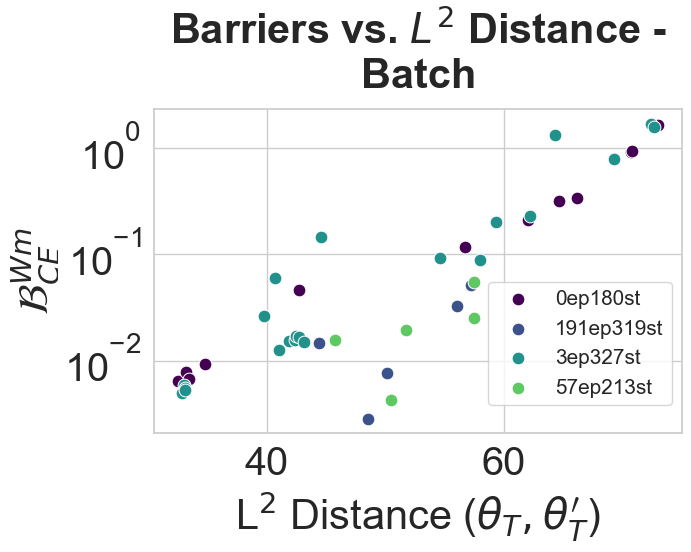

gaussian 32
hello l2_dist_1-2 l2_dist_1-2 True


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved figure to out/butterfly/finetune-rebuttal/scatter/l2-barr-group-cifar100-to-10-gaussian-lmc-0-1-loss-weighted-barrier.png


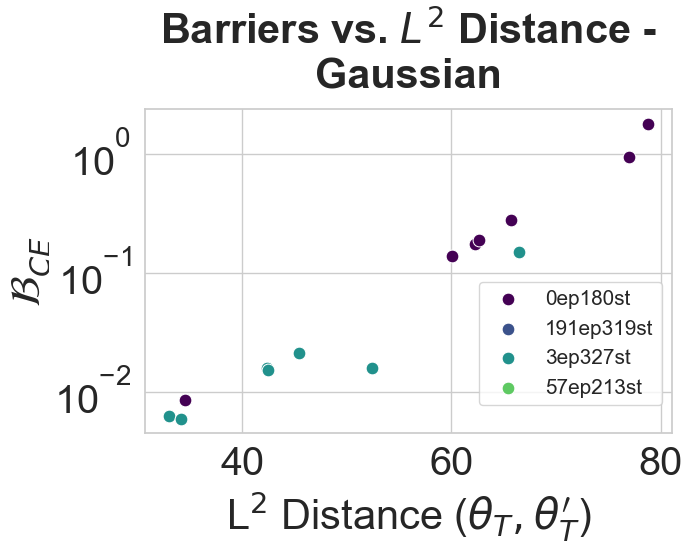

gaussian 32
hello l2_dist_1-2 l2_dist_1-2 True
Saved figure to out/butterfly/finetune-rebuttal/scatter/l2-barr-group-cifar100-to-10-gaussian-perm-wm-0-1-loss-weighted-barrier.png


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


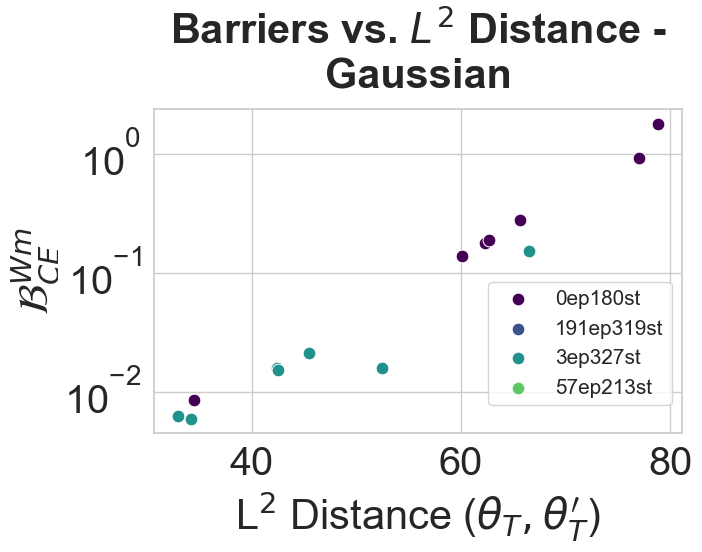

In [41]:
# group = "standard-sanity"
group = "cifar100-to-10"
# filters = merged_df["run.group"] == group
filters = (
    (merged_df["data.random_labels"] != True)
    & (merged_df["run.group"] != "rand-labels")
    & (merged_df["run.group"] == "cifar10-resnet50-")
    & ~(merged_df["bert_ckpt"].isna())
    & (merged_df["model2.train.cross_entropy"] < 0.4)
    &(merged_df[registry.get_metric("l2_dist_1-2").flat_name] != "null")
    & (merged_df["trainer.opt.warmup_ratio"] > 0)
    & (merged_df["model1.train.cross_entropy"] < 0.5)
    & (merged_df["model2.train.cross_entropy"] < 0.5)
    &(merged_df["data.dataset"].isin(["cifar10"])
))



for perturb_method in ["batch", "gaussian"]:
    for base_prefix in ["lmc", "perm_wm"]:
        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "l2_dist_1-2"
        legend_template = "{}"
        labels = ["bert_ckpt"]
        # labels = ["data.dataset"]
        # # labels=["perturb_step_relative"]
        # labels=["pretty_group"]

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
        print(perturb_method, len(tmp))
        title = f"Barriers vs. $L^2$ Distance - {perturb_method.title()}"
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=True,
            plot_type="scatter",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
            # legend_title="Spawning checkpoint",
            legend_title="",
            # hue_cnt=6,
            ncols=4,
            save_fig=True,
            # xscale="log",
            yscale="log",
            save_prefix=f"l2-barr-group-{group}",
            out_dir=out.joinpath("scatter"),
            zoom_first_step=0,
            zoom_last_step=0.05,
            uncertainty=False,
            inset_fig=False,
            inset_pos="right",
            zoom_y_last_step=0.3,
            x_label=r"L$^2$ Distance ($\theta_T, \theta_T^\prime$)",
        )

In [42]:
## fixed pts

batch 79
hello perm_wm_fixed_ponts_1_2 perm_wm_fixed_ponts_1_2 True


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved figure to out/butterfly/finetune-rebuttal/scatter/fixed-barr-group-cifar100-to-10-batch-lmc-0-1-loss-weighted-barrier.png


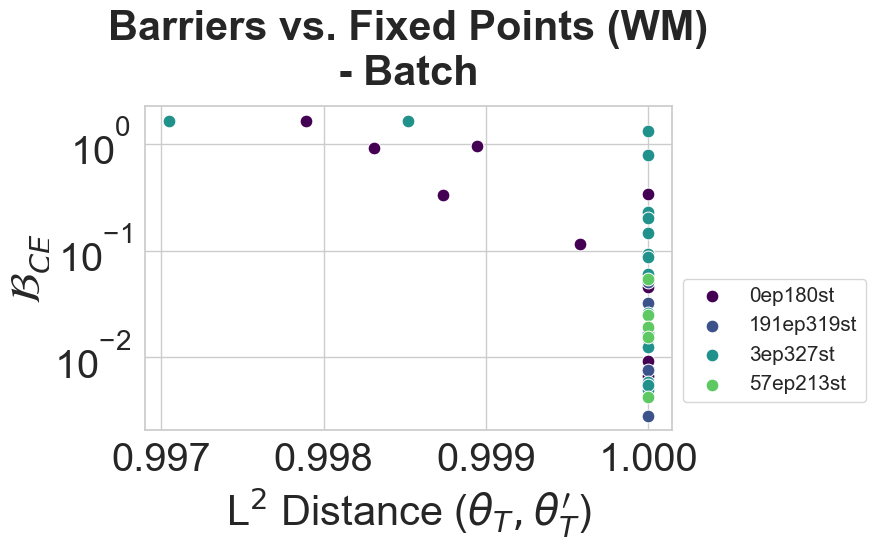

batch 79
hello perm_wm_fixed_ponts_1_2 perm_wm_fixed_ponts_1_2 True
Saved figure to out/butterfly/finetune-rebuttal/scatter/fixed-barr-group-cifar100-to-10-batch-perm-wm-0-1-loss-weighted-barrier.png


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


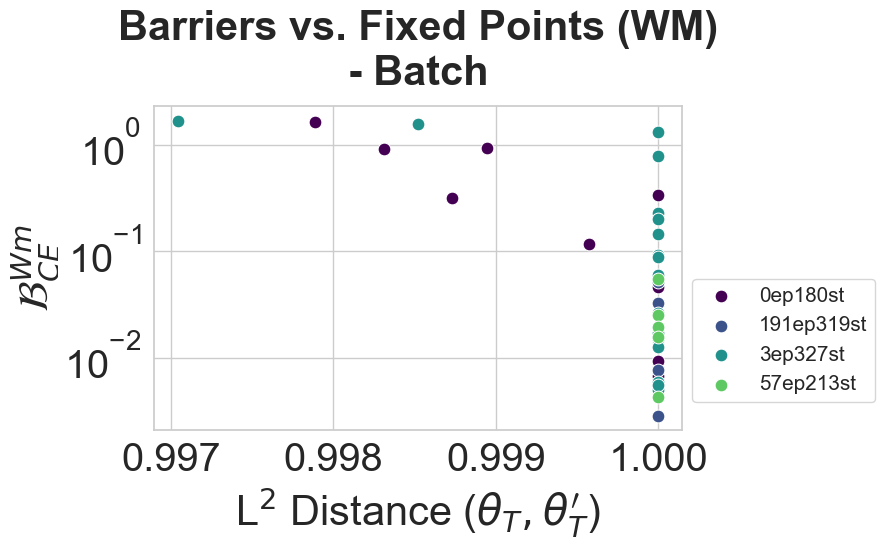

gaussian 32
hello perm_wm_fixed_ponts_1_2 perm_wm_fixed_ponts_1_2 True
Saved figure to out/butterfly/finetune-rebuttal/scatter/fixed-barr-group-cifar100-to-10-gaussian-lmc-0-1-loss-weighted-barrier.png


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


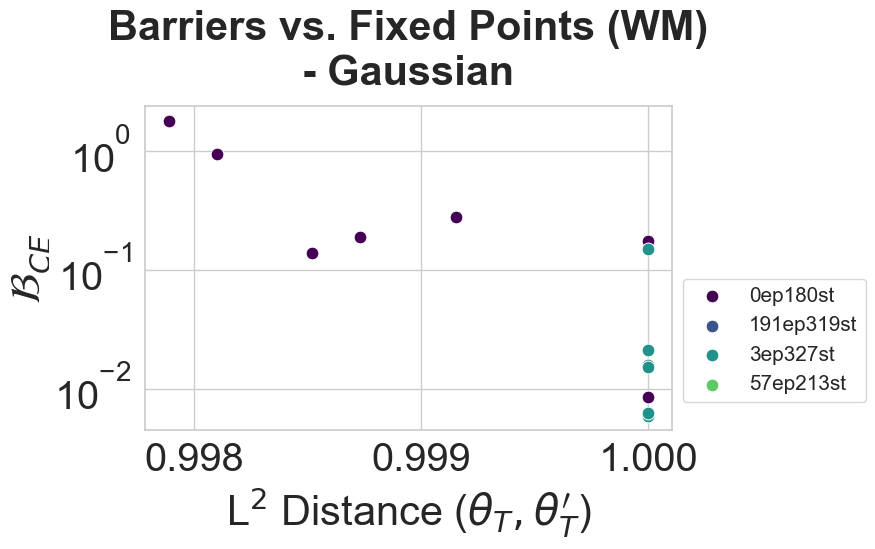

gaussian 32
hello perm_wm_fixed_ponts_1_2 perm_wm_fixed_ponts_1_2 True
Saved figure to out/butterfly/finetune-rebuttal/scatter/fixed-barr-group-cifar100-to-10-gaussian-perm-wm-0-1-loss-weighted-barrier.png


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


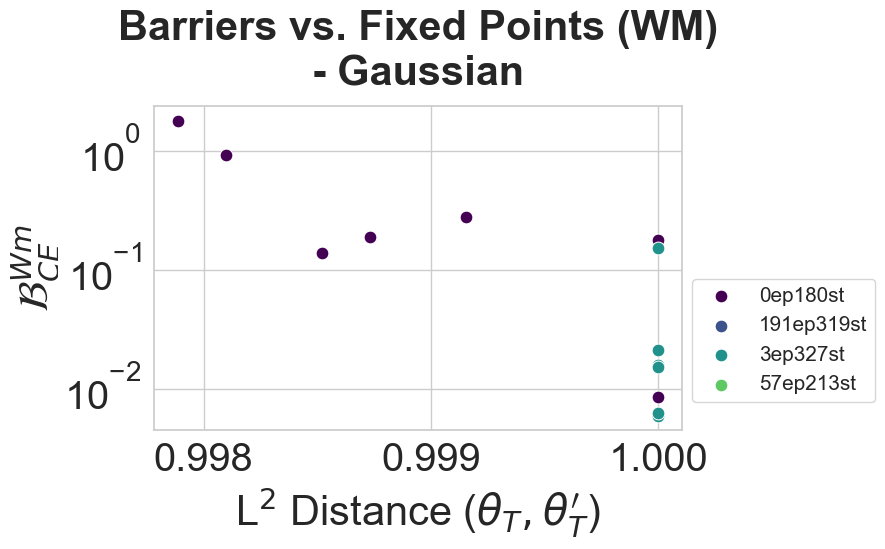

In [43]:
### fixed pts

# group = "standard-sanity"
group = "cifar100-to-10"
# filters = merged_df["run.group"] == group
filters = (
    (merged_df["data.random_labels"] != True)
    & (merged_df["run.group"] != "rand-labels")
    & (merged_df["run.group"] == "cifar10-resnet50-")
    & ~(merged_df["bert_ckpt"].isna())
    & (merged_df["model2.train.cross_entropy"] < 0.4)
    &(merged_df[registry.get_metric("l2_dist_1-2").flat_name] != "null")
    & (merged_df["trainer.opt.warmup_ratio"] > 0)
    & (merged_df["model1.train.cross_entropy"] < 0.5)
    & (merged_df["model2.train.cross_entropy"] < 0.5)
    &(merged_df["data.dataset"].isin(["cifar10"])
))



for perturb_method in ["batch", "gaussian"]:
    for base_prefix in ["lmc", "perm_wm"]:
        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "l2_dist_1-2"
        x_metric = "perm_wm_fixed_ponts_1_2"
        legend_template = "{}"
        labels = ["bert_ckpt"]
        # labels = ["data.dataset"]
        # # labels=["perturb_step_relative"]
        # labels=["pretty_group"]

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
        print(perturb_method, len(tmp))
        title = f"Barriers vs. Fixed Points (WM) - {perturb_method.title()}"
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=True,
            plot_type="scatter",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
            # legend_title="Spawning checkpoint",
            legend_title="",
            # hue_cnt=6,
            ncols=4,
            save_fig=True,
            # xscale="log",
            yscale="log",
            save_prefix=f"fixed-barr-group-{group}",
            out_dir=out.joinpath("scatter"),
            zoom_first_step=0,
            zoom_last_step=0.05,
            uncertainty=False,
            inset_fig=False,
            inset_pos="right",
            zoom_y_last_step=0.3,
            x_label=r"L$^2$ Distance ($\theta_T, \theta_T^\prime$)",
        )

## Cifar 10->100


In [218]:

group = "cifar10-to-100"
filters_ = (merged_df["data.dataset"] == "cifar100") & (
    merged_df["model1.train.cross_entropy"] <= 0.4
)


filters_ = (
    (merged_df["data.dataset"] == "cifar100") 
    & (merged_df["data.random_labels"] != True)
    & (merged_df["run.group"] != "rand-labels")
    & ~(merged_df["bert_ckpt"].isna())
    & (merged_df["model2.train.cross_entropy"] < 0.4)
    & (merged_df["model1.train.cross_entropy"] < 0.4)
)

merged_df["lmc-0-1.lmc.loss.weighted.barrier_train"]

merged_df[filters_].pivot_table(index="bert_ckpt", values=["model2.test.accuracy", "model2.train.accuracy", "lmc-0-1.lmc.loss.weighted.barrier_train"], aggfunc=mean_std)

lmc-0-1.lmc.loss.weighted.barrier_train model2.test.accuracy  \
bert_ckpt                                                                 
0ep180st                               2.22 ± 1.56          0.65 ± 0.01   
191ep319st                             0.02 ± 0.05          0.72 ± 0.00   
3ep327st                               0.49 ± 1.04          0.67 ± 0.00   
57ep213st                              0.02 ± 0.05          0.72 ± 0.00   

           model2.train.accuracy  
bert_ckpt                         
0ep180st             0.96 ± 0.01  
191ep319st           0.99 ± 0.00  
3ep327st             0.98 ± 0.00  
57ep213st            0.99 ± 0.00

batch
22
hello perturb_scale perturb_scale False
perturb_scale perturb_scale None
$\sigma$
Saved figure to out/butterfly/finetune-rebuttal/cifar10-to-100-early-batch-lmc-0-1-loss-weighted-barrier.pdf


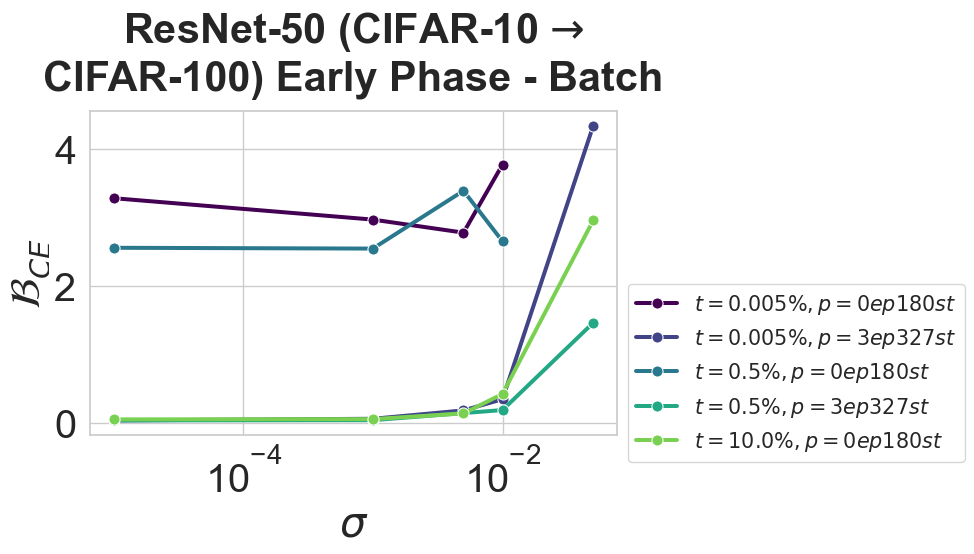

22
hello perturb_scale perturb_scale False
perturb_scale perturb_scale None
$\sigma$
Saved figure to out/butterfly/finetune-rebuttal/cifar10-to-100-early-batch-perm-wm-0-1-loss-weighted-barrier.pdf


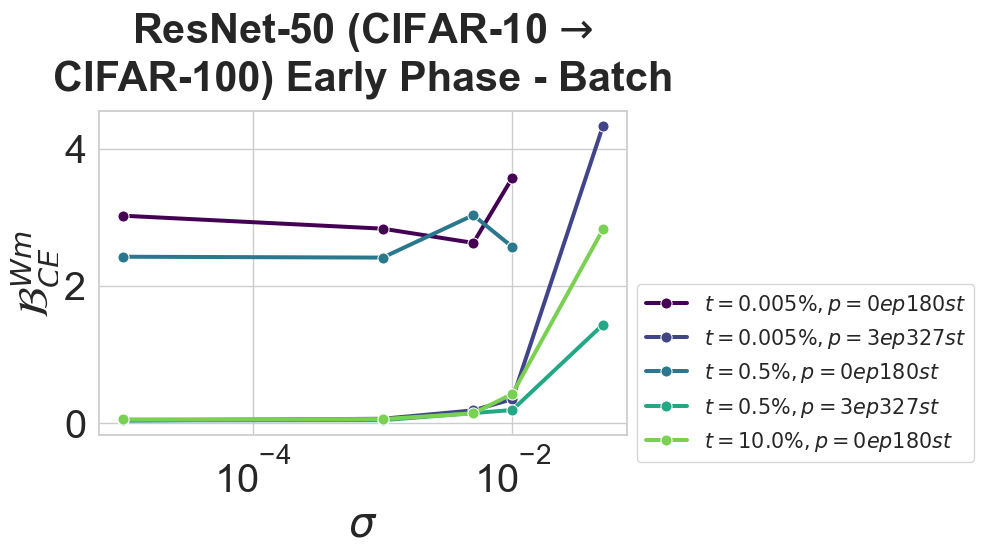

gaussian
17
hello perturb_scale perturb_scale False
perturb_scale perturb_scale None
$\sigma$
Saved figure to out/butterfly/finetune-rebuttal/cifar10-to-100-early-gaussian-lmc-0-1-loss-weighted-barrier.pdf


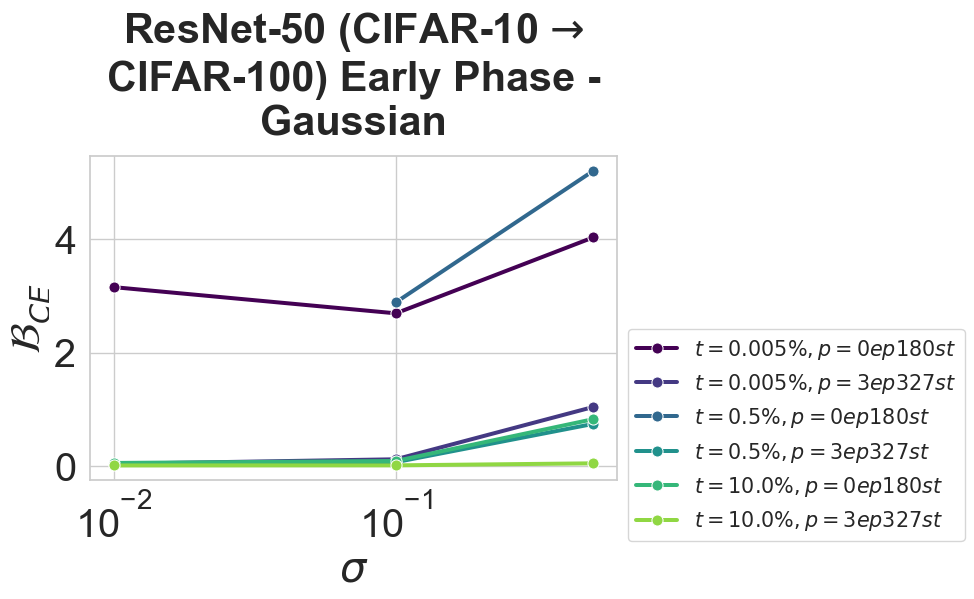

17
hello perturb_scale perturb_scale False
perturb_scale perturb_scale None
$\sigma$
Saved figure to out/butterfly/finetune-rebuttal/cifar10-to-100-early-gaussian-perm-wm-0-1-loss-weighted-barrier.pdf


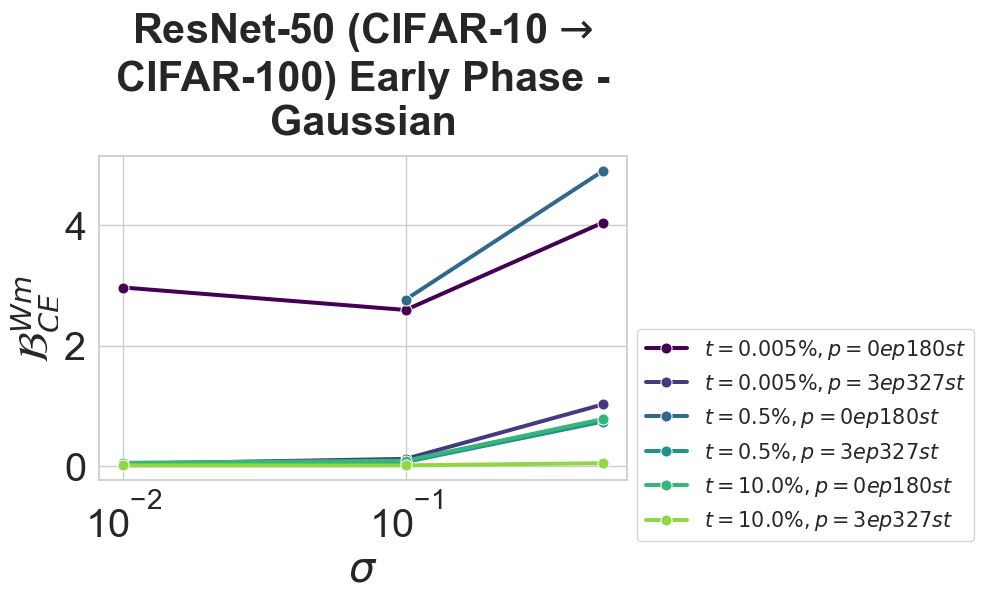

batch
58
hello perturb_scale perturb_scale False
perturb_scale perturb_scale None
$\sigma$
Saved figure to out/butterfly/finetune-rebuttal/cifar10-to-100-late-batch-lmc-0-1-loss-weighted-barrier.pdf


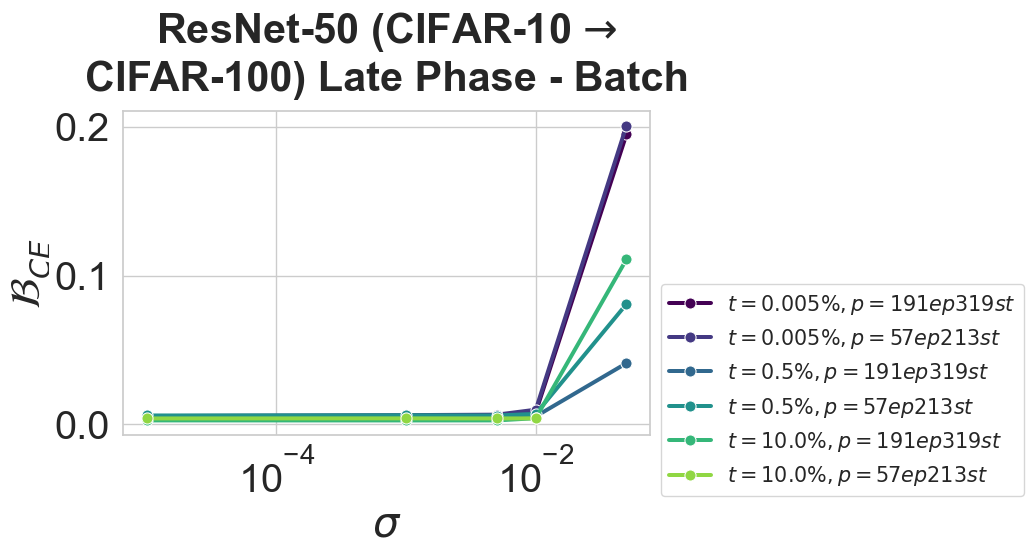

58
hello perturb_scale perturb_scale False
perturb_scale perturb_scale None
$\sigma$
Saved figure to out/butterfly/finetune-rebuttal/cifar10-to-100-late-batch-perm-wm-0-1-loss-weighted-barrier.pdf


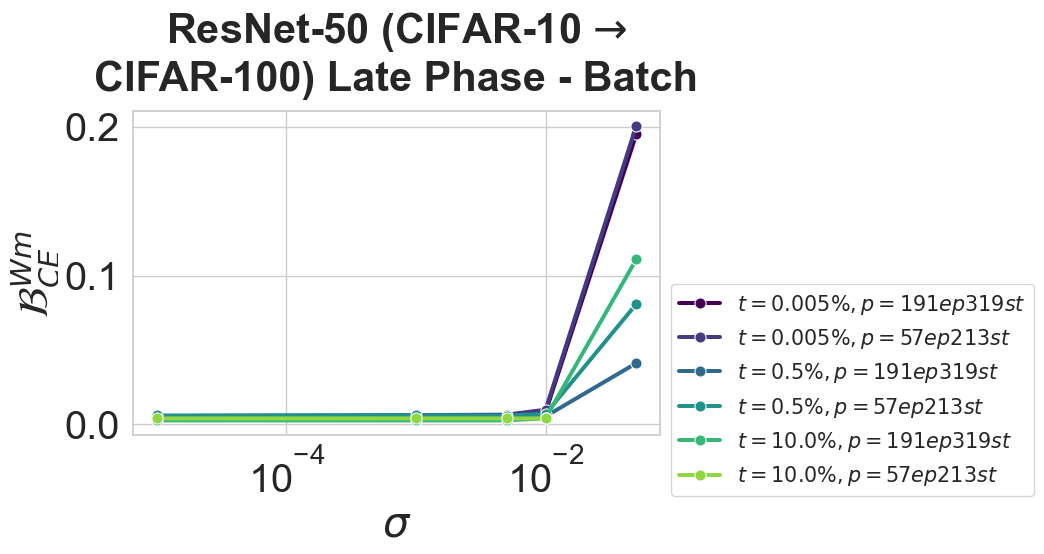

gaussian
18
hello perturb_scale perturb_scale False
perturb_scale perturb_scale None
$\sigma$
Saved figure to out/butterfly/finetune-rebuttal/cifar10-to-100-late-gaussian-lmc-0-1-loss-weighted-barrier.pdf


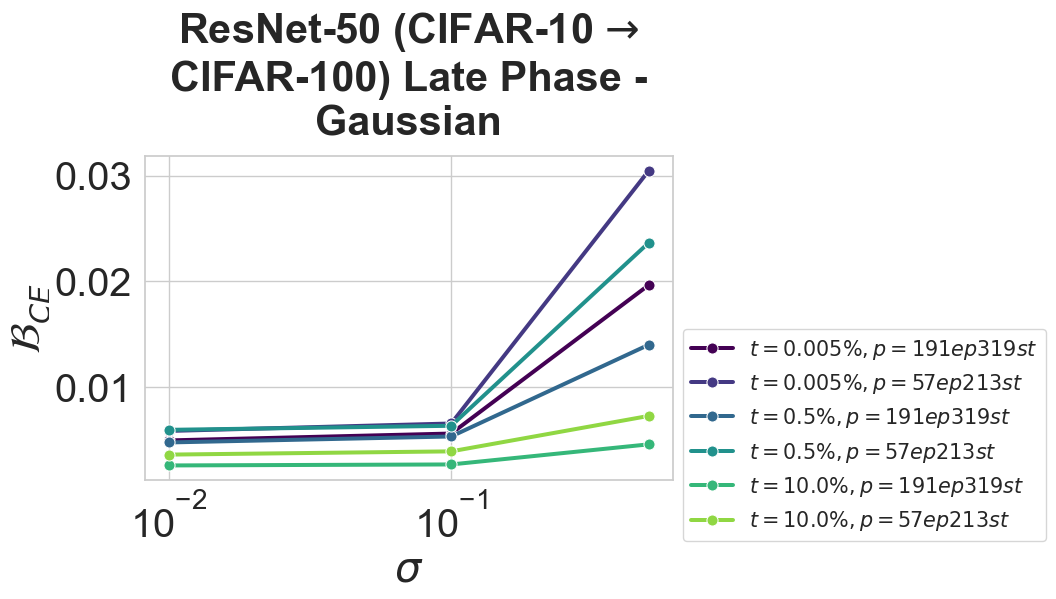

18
hello perturb_scale perturb_scale False
perturb_scale perturb_scale None
$\sigma$
Saved figure to out/butterfly/finetune-rebuttal/cifar10-to-100-late-gaussian-perm-wm-0-1-loss-weighted-barrier.pdf


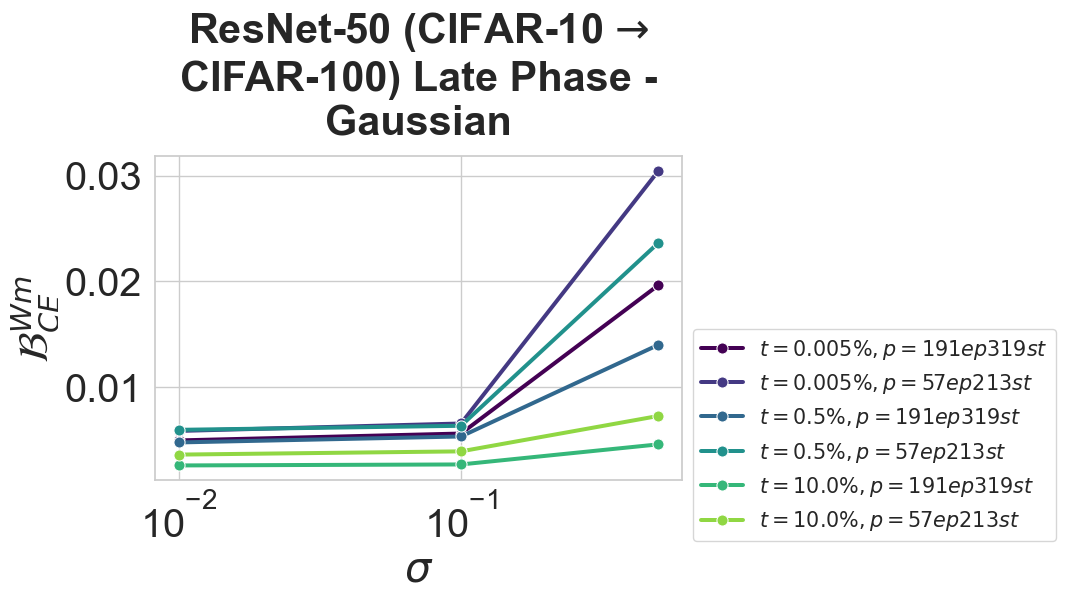

In [202]:
group = "cifar10-to-100"
filters_ = (merged_df["data.dataset"] == "cifar100") & (
    merged_df["model1.train.cross_entropy"] <= 0.4
)


filters_ = (
    (merged_df["data.dataset"] == "cifar100") & 
    (merged_df["data.random_labels"] != True)
    & (merged_df["run.group"] != "rand-labels")
    & ~(merged_df["bert_ckpt"].isna())
    & (merged_df["model2.train.cross_entropy"] < 0.4)
    & (merged_df["model1.train.cross_entropy"] < 0.4)
)


ckpt_groups = [
    ("early", ("0ep180st", "3ep327st")),
    ("late", ("57ep213st", "191ep319st")),
]
for phase, ckpt_group in ckpt_groups:
    filters = (
        filters_
        & (merged_df["data.dataset"] == "cifar100")
        & merged_df["bert_ckpt"].isin(ckpt_group)
    )
    group = f"cifar10-to-100-{phase}"
    # for perturb_method in ["batch"]:
    for perturb_method in merged_df[filters]["perturb_mode"].unique():
        print(perturb_method)
        for base_prefix in ["lmc", "perm_wm"]:
            base_name = f"{base_prefix}_loss_train_0_1"
            zoom = None
            x_metric = "perturb_scale"
            legend_template = r"$t={} \%, p={}$"
            labels = ["perturb_step_relative", "bert_ckpt"]

            tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
            print(len(tmp))
            title = f"ResNet-50 (CIFAR-10 $\\to$ CIFAR-100) {phase.title()} Phase - {perturb_method.title()}"
            t = plot_perturb_barrier(
                tmp,
                registry,
                perturb_method,
                base_name,
                zoom=zoom,
                filter_bad_runs=False,
                separate_legend=True,
                plot_type="line",
                title=title,
                x_metric=x_metric,
                labels=labels,
                legend_template=legend_template,
            legend_title="",
                # legend_title="Perturbed At, Spawning Checkpoint",
                # hue_cnt=5,
                ncols=3,
                save_fig=True,
                xscale="log",
                save_prefix=group,
                out_dir=out,
                uncertainty=True,
                inset_fig=False,
                inset_pos="bottom-left",
                zoom_first_step=0,
                zoom_last_step=0.05,
                zoom_y_last_step=0.1,
            )

## Performance

80
hello test_accuracy_2 test_accuracy_2 True
WandbMetric(log_name='model2/test/accuracy', ylabel='$\\mathrm{Acc}^{2}_{\\mathrm{Te}}$', prefix='model2-acc', category=<MetricCategory.ACCURACY: 'accuracy'>, split=<Split.TEST: 'test'>, general_ylabel='$\\mathrm{Acc}^{2}_{\\mathrm{}}$', flat_name='model2.test.accuracy') model2.test.accuracy None
None


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


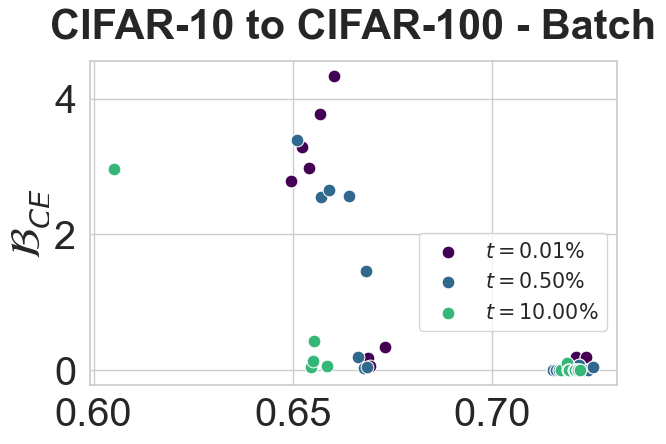

In [179]:
perturb_method = "batch"

group = dataset
dataset = "Cifar100"
filters_ = (
    (merged_df["data.dataset"] == dataset.lower()) 
    # (merged_df["trainer.opt.warmup_ratio"] > 0)
    # & (merged_df["perturb_step"] > 0)
    & (merged_df["model2.train.accuracy"] > 0.9)
    # & (merged_df["model1.train.accuracy"] > 0.9)
    & ~(merged_df["run.group"] == "rand-labels")
    & ~(merged_df["bert_ckpt"].isna())
    # & (merged_df["model2.train.cross_entropy"] < 0.4)
    # & (merged_df["model1.train.cross_entropy"] < 0.4)
)
if True:
# for bert_ckpt in merged_df["bert_ckpt"].unique():
    # for ckpt in merged_df["bert_ckpt"].unique():
    # filters = filters_ & (merged_df["bert_ckpt"] == bert_ckpt)
    filters = filters_
    for base_prefix in ["lmc"]:
    # for base_prefix in ["lmc", "perm_wm"]:
        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "perturb_scale"
        legend_template = r"$t={:.2f}\%$"
        labels = ["perturb_step_relative"]
        # labels = ["bert_ckpt"]
        # labels=["bert_ckpt", "perturb_step_relative"]
        x_metric = f"test_accuracy_2"
        xscale="linear"

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
        print(len(tmp))
        title = f"{bert_ckpt} to {dataset.upper()} - {perturb_method.title()}"
        title = f"CIFAR-10 to CIFAR-100 - {perturb_method.title()}"
        
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=False,
            # separate_legend=True,
            plot_type="scatter",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
        legend_title="",
            # legend_title="Perturbed at",
            # hue_cnt=5,
            ncols=4,
            save_fig=False,
            xscale=xscale,
            yscale="linear",
            out_dir=out,
            uncertainty=True,
            file_extension="png",
            save_prefix=f"vit-{group}"
        )

198
hello test_accuracy_1 test_accuracy_1 True
WandbMetric(log_name='model1/test/accuracy', ylabel='$\\mathrm{Acc}^{1}_{\\mathrm{Te}}$', prefix='model1-acc', category=<MetricCategory.ACCURACY: 'accuracy'>, split=<Split.TEST: 'test'>, general_ylabel='$\\mathrm{Acc}^{1}_{\\mathrm{}}$', flat_name='model1.test.accuracy') model1.test.accuracy None
$\mathrm{Acc}^{1}_{\mathrm{Te}}$


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


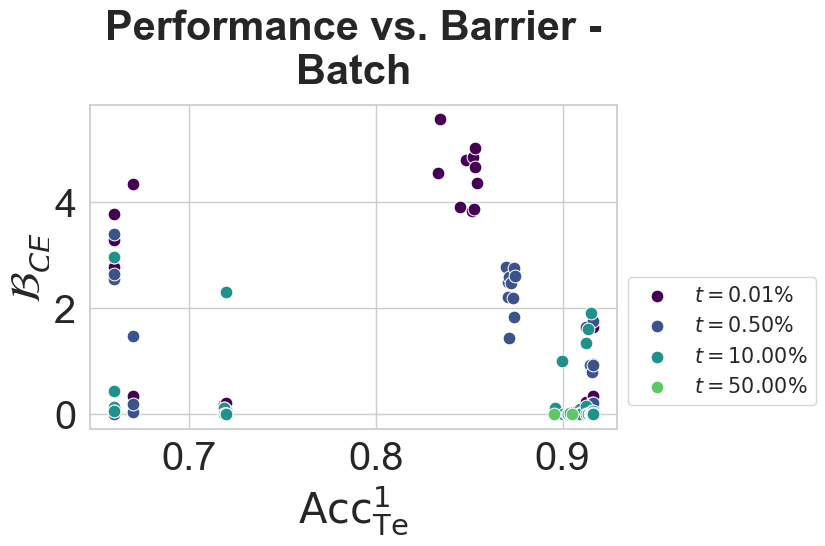

In [139]:
## all together

perturb_method = "batch"

# group = dataset
# dataset = "Cifar100"

filters_ = (
    # (merged_df["trainer.opt.warmup_ratio"] > 0)
    # & (merged_df["perturb_step"] > 0)
    # & (merged_df["model2.train.accuracy"] > 0.9)
    # & (merged_df["model1.train.accuracy"] > 0.9)
    ~(merged_df["run.group"] == "rand-labels")
    & ~(merged_df["bert_ckpt"].isna())
    # & (merged_df["model2.train.cross_entropy"] < 0.4)
    # & (merged_df["model1.train.cross_entropy"] < 0.4)
)
if True:
# for bert_ckpt in merged_df["bert_ckpt"].unique():
    # for ckpt in merged_df["bert_ckpt"].unique():
    # filters = filters_ & (merged_df["bert_ckpt"] == bert_ckpt)
    filters = filters_
    for base_prefix in ["lmc"]:
    # for base_prefix in ["lmc", "perm_wm"]:
        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "perturb_scale"
        legend_template = r"$t={:.2f}\%$"
        labels = ["perturb_step_relative"]
        # labels = ["bert_ckpt"]
        # labels=["bert_ckpt", "perturb_step_relative"]
        x_metric = f"test_accuracy_1"
        xscale="linear"

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
        print(len(tmp))
        title = f"Performance vs. Barrier - {perturb_method.title()}"
        
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=False,
            # separate_legend=True,
            plot_type="scatter",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
        legend_title="",
            # legend_title="Perturbed at",
            # hue_cnt=5,
            ncols=4,
            save_fig=False,
            xscale=xscale,
            yscale="linear",
            out_dir=out,
            uncertainty=True,
            file_extension="png",
            save_prefix=f"vit-{group}"
        )

In [118]:
merged_df["model1.test.accuracy"].min()

0.09999999969005584

### L2

batch 80
hello l2_dist_1-2 l2_dist_1-2 True
Saved figure to out/butterfly/finetune-rebuttal/scatter/l2-barr-group-cifar10-to-100-batch-lmc-0-1-loss-weighted-barrier.png


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


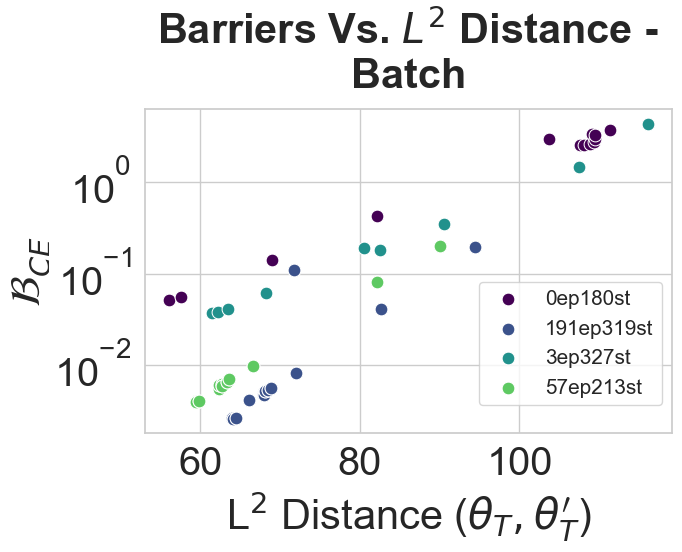

batch 80
hello l2_dist_1-2 l2_dist_1-2 True
Saved figure to out/butterfly/finetune-rebuttal/scatter/l2-barr-group-cifar10-to-100-batch-perm-wm-0-1-loss-weighted-barrier.png


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


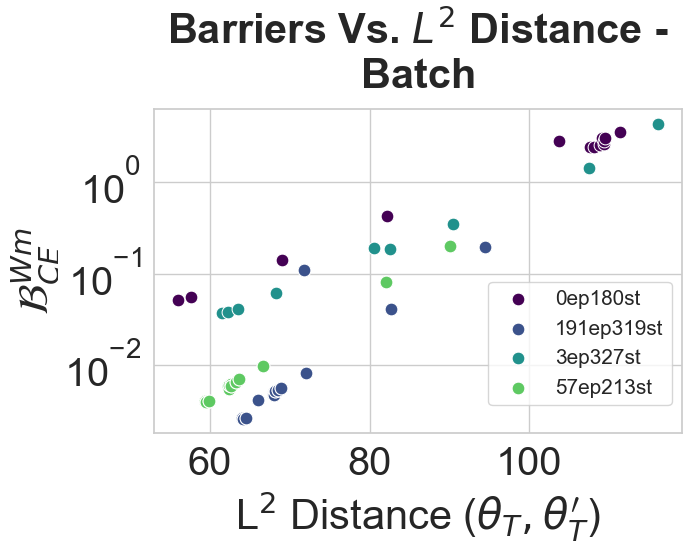

gaussian 35
hello l2_dist_1-2 l2_dist_1-2 True
Saved figure to out/butterfly/finetune-rebuttal/scatter/l2-barr-group-cifar10-to-100-gaussian-lmc-0-1-loss-weighted-barrier.png


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


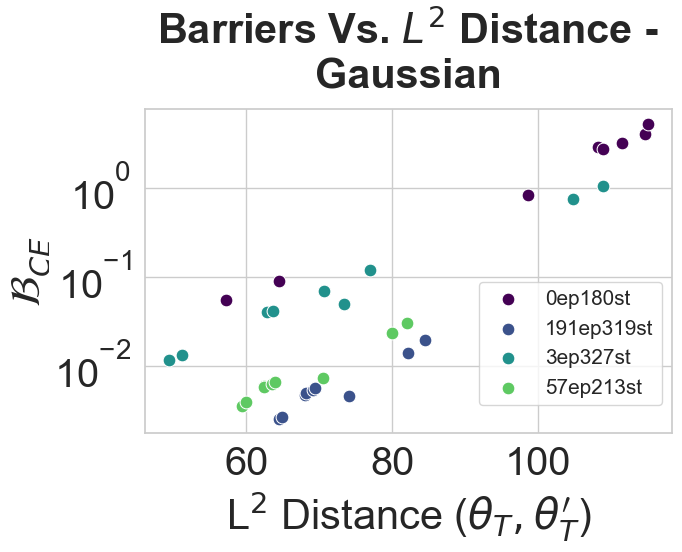

gaussian 35
hello l2_dist_1-2 l2_dist_1-2 True
Saved figure to out/butterfly/finetune-rebuttal/scatter/l2-barr-group-cifar10-to-100-gaussian-perm-wm-0-1-loss-weighted-barrier.png


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


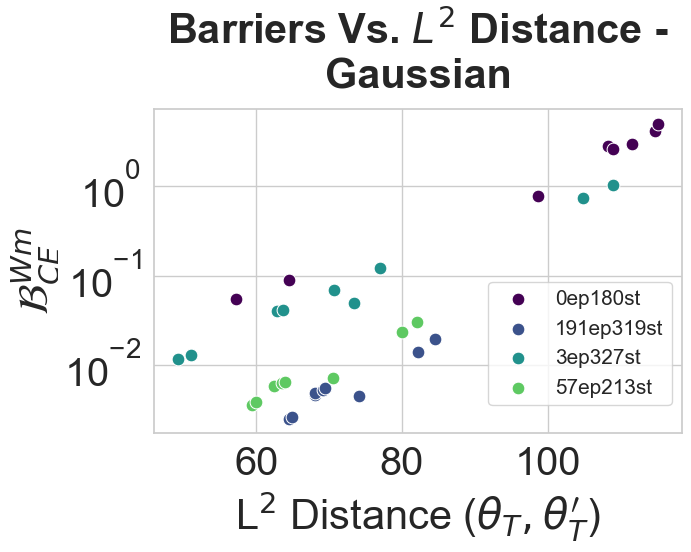

In [45]:
group = "cifar10-to-100"

filters = (
    (merged_df["data.random_labels"] != True)
    & (merged_df["run.group"] != "rand-labels")
    & (merged_df["run.group"] != "cifar10-resnet50-")
    & ~(merged_df["bert_ckpt"].isna())
    & (merged_df["model2.train.cross_entropy"] < 0.4)
    &(merged_df[registry.get_metric("l2_dist_1-2").flat_name] != "null")
    & (merged_df["trainer.opt.warmup_ratio"] > 0)
    & (merged_df["model1.train.cross_entropy"] < 0.5)
    & (merged_df["model2.train.cross_entropy"] < 0.5)
    &(merged_df["data.dataset"].isin(["cifar100"])
))


for perturb_method in ["batch", "gaussian"]:
    for base_prefix in ["lmc", "perm_wm"]:
        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "l2_dist_1-2"
        legend_template = "{}"
        labels = ["bert_ckpt"]
        # labels = ["data.dataset"]
        # # labels=["perturb_step_relative"]
        # labels=["pretty_group"]

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
        print(perturb_method, len(tmp))
        title = f"Barriers vs. $L^2$ Distance - {perturb_method}".title()
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=True,
            plot_type="scatter",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
            legend_title="",
            # legend_title="Spawning checkpoint",
            # hue_cnt=6,
            ncols=4,
            save_fig=True,
            # xscale="log",
            yscale="log",
            save_prefix=f"l2-barr-group-{group}",
            out_dir=out.joinpath("scatter"),
            zoom_first_step=0,
            zoom_last_step=0.05,
            uncertainty=False,
            inset_fig=False,
            inset_pos="right",
            zoom_y_last_step=0.3,
            x_label=r"L$^2$ Distance ($\theta_T, \theta_T^\prime$)",
        )

# ViT

In [210]:
api.flush()
# out = Path("out/finetuning/multibert")
out.mkdir(exist_ok=True, parents=True)

project_path = "gsaltintas/LMCFinetuning-VIT"
runs = api.runs(
    project_path,
    filters={
        "tags": {"$nin": ["ignore", "delete"]},
        # "config.data.dataset": {"$nin": ["cifar10"]},
    },
)
len(runs)

406

In [211]:
main_df, registry = get_merged_df(
    runs,
    scale_barriers=False,
    performance_aware=False,
    find_missing=False,
    return_registry=True,
)
main_df["bert_ckpt"] = main_df["model.model_name"] #.str.split("step_").str[1]

na_filters = (
    # (main_df["model1.test.accuracy"] != "null")
    (main_df["model1.train.cross_entropy"] != "NaN")
    & (main_df["model2.train.cross_entropy"] != "NaN")
    & (main_df["model1.train.cross_entropy"] != "null")
    & (main_df["model2.train.cross_entropy"] != "null")
    & (~main_df["model1.train.cross_entropy"].isna())
    & (~main_df["model2.train.cross_entropy"].isna())
    & (~main_df[registry.get_metric("lmc_loss_train_0_1").flat_name].isna())
    & (main_df[registry.get_metric("lmc_loss_train_0_1").flat_name] != "null")
    & (~main_df["bert_ckpt"].isna())
    
)

merged_df = main_df[na_filters]
merged_df["steps_"] = merged_df.apply(get_steps, axis=1)
merged_df["perturb_step_log"] = merged_df["perturb_step"].apply(np.log)
merged_df["perturb_step_relative"] = merged_df.apply(
    lambda row: row["perturb_step"] / float(row["steps_"]) * 100, axis=1
)
merged_df["pretty_group"] = merged_df.apply(
    lambda row: f"{row['data.dataset']}-{row['bert_ckpt']}", axis=1
)
# Combine filters and apply them in one step
# merged_df = merged_df.apply(rename_opt_lr, axis=1)
# code_name = merged_df["run.group"].apply(extract_model_name).apply(correct_cases).rename("code_name")
# Calculate mean and use pd.concat for efficiency
# average_test_acc = (
#     merged_df[["model1.test.accuracy", "model2.test.accuracy"]].mean(axis=1) * 100
# ).rename("average_test_acc")
# average_train_acc = (
#     merged_df[["model1.train.accuracy", "model2.train.accuracy"]].mean(axis=1) * 100
# ).rename("average_train_acc")
# merged_df = pd.concat([merged_df, average_test_acc, average_train_acc], axis=1)
merged_df.loc[merged_df["perturb_step"] == -1, "perturb_step"] = 0

# further_filters = (
#      (merged_df["trainer.opt.lr"] == 0.1)
#     & check_nulls(merged_df, wandb_keys.get_metric("lmc_loss_train_0_1").flat_name)
#     & (merged_df["average_test_acc"] >= 0.7)
#     & (merged_df["model2.test.accuracy"] >= 0.8)
#     & (merged_df["epoch"] >= 50)
# )

len(merged_df)

/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:171: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["trainer.opt.warmup_ratio"].fillna(0, inplace=True)
/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:172: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'null' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.fillna("null", inplace=True)
/var/folders/8n/l2sy_xn

157

In [213]:
filt = ((merged_df["model.model_name"] == "google/vit-base-patch16-224")
        & (merged_df["lmc-0-1.lmc.loss.weighted.barrier_train"] != "null")
)
filt.sum()
from pprint import pprint

merged_df[filt][["model2.train.accuracy", "model2.test.accuracy"]].mean()
merged_df[filt].pivot_table(index="bert_ckpt", values=["model2.test.accuracy", "model2.train.accuracy", "lmc-0-1.lmc.loss.weighted.barrier_train"], aggfunc=mean_std)


lmc-0-1.lmc.loss.weighted.barrier_train  \
bert_ckpt                                                             
google/vit-base-patch16-224                             0.17 ± 0.34   

                            model2.test.accuracy model2.train.accuracy  
bert_ckpt                                                               
google/vit-base-patch16-224          0.91 ± 0.00           0.99 ± 0.00

4
hello test_accuracy_2 test_accuracy_2 True
WandbMetric(log_name='model2/test/accuracy', ylabel='$\\mathrm{Acc}^{2}_{\\mathrm{Te}}$', prefix='model2-acc', category=<MetricCategory.ACCURACY: 'accuracy'>, split=<Split.TEST: 'test'>, general_ylabel='$\\mathrm{Acc}^{2}_{\\mathrm{}}$', flat_name='model2.test.accuracy') model2.test.accuracy None
None
Saved figure to out/butterfly/finetune-rebuttal/vit-Cifar100-batch-lmc-0-1-loss-weighted-barrier.png


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


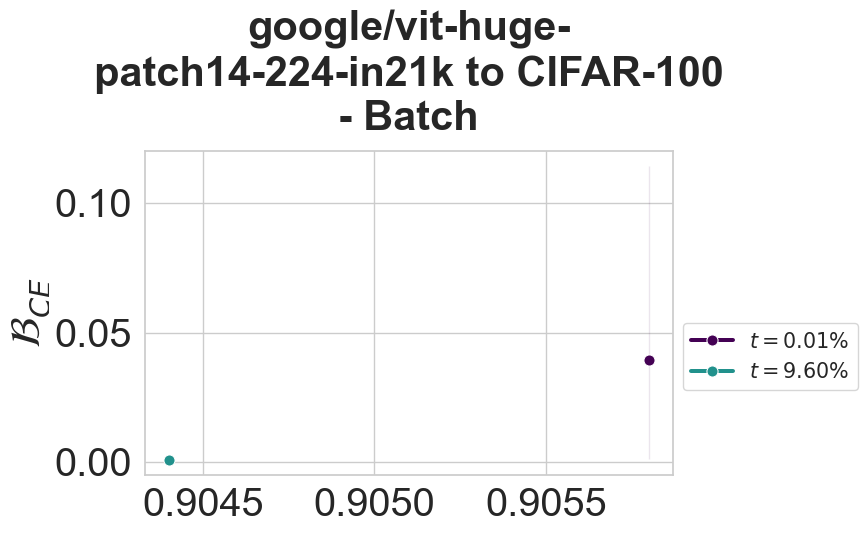

18
hello test_accuracy_2 test_accuracy_2 True
WandbMetric(log_name='model2/test/accuracy', ylabel='$\\mathrm{Acc}^{2}_{\\mathrm{Te}}$', prefix='model2-acc', category=<MetricCategory.ACCURACY: 'accuracy'>, split=<Split.TEST: 'test'>, general_ylabel='$\\mathrm{Acc}^{2}_{\\mathrm{}}$', flat_name='model2.test.accuracy') model2.test.accuracy None
None


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved figure to out/butterfly/finetune-rebuttal/vit-Cifar100-batch-lmc-0-1-loss-weighted-barrier.png


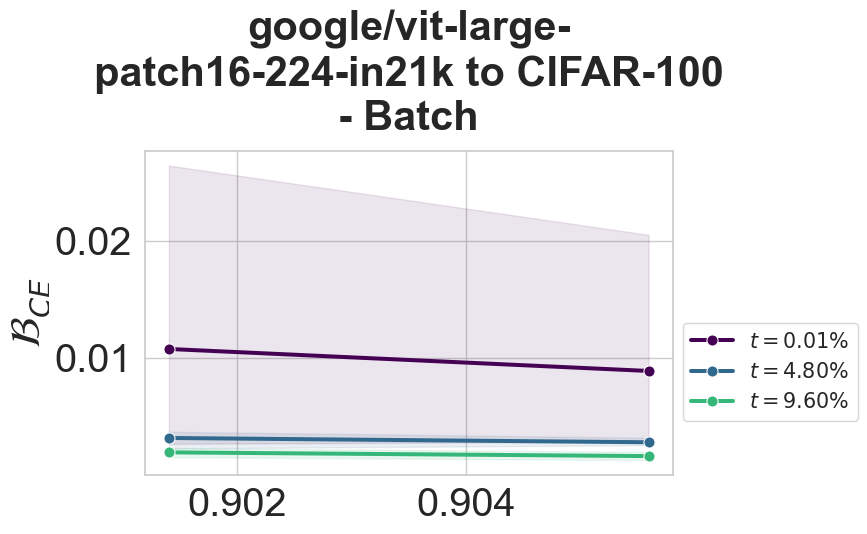

24
hello test_accuracy_2 test_accuracy_2 True
WandbMetric(log_name='model2/test/accuracy', ylabel='$\\mathrm{Acc}^{2}_{\\mathrm{Te}}$', prefix='model2-acc', category=<MetricCategory.ACCURACY: 'accuracy'>, split=<Split.TEST: 'test'>, general_ylabel='$\\mathrm{Acc}^{2}_{\\mathrm{}}$', flat_name='model2.test.accuracy') model2.test.accuracy None
None
Saved figure to out/butterfly/finetune-rebuttal/vit-Cifar100-batch-lmc-0-1-loss-weighted-barrier.png


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


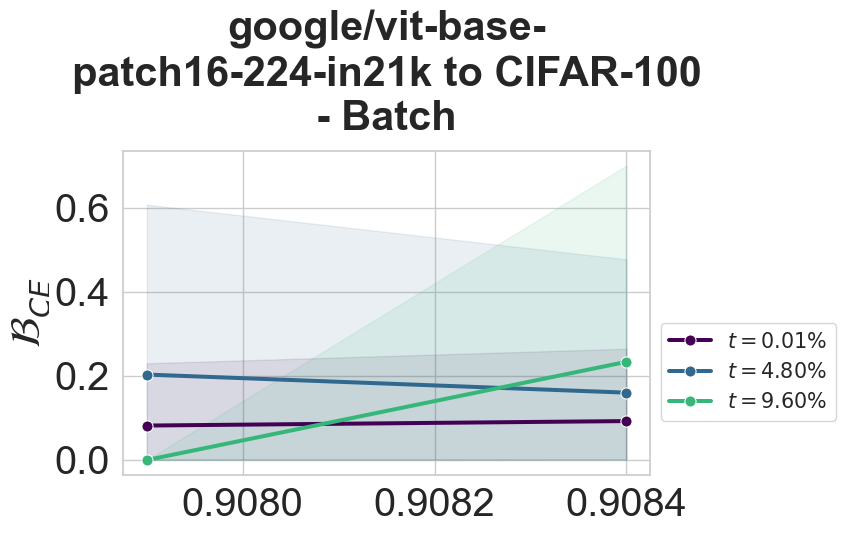

48
hello test_accuracy_2 test_accuracy_2 True
WandbMetric(log_name='model2/test/accuracy', ylabel='$\\mathrm{Acc}^{2}_{\\mathrm{Te}}$', prefix='model2-acc', category=<MetricCategory.ACCURACY: 'accuracy'>, split=<Split.TEST: 'test'>, general_ylabel='$\\mathrm{Acc}^{2}_{\\mathrm{}}$', flat_name='model2.test.accuracy') model2.test.accuracy None
None
Saved figure to out/butterfly/finetune-rebuttal/vit-Cifar100-batch-lmc-0-1-loss-weighted-barrier.png


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


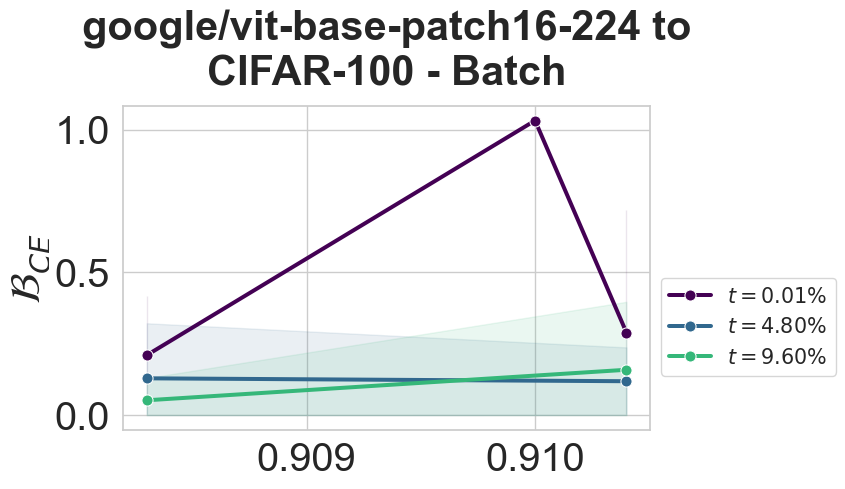

In [183]:
perturb_method = "batch"

group = dataset
dataset = "Cifar-100"
filters_ = (
    # (merged_df["data.dataset"] == dataset) & 
    (merged_df["trainer.opt.warmup_ratio"] > 0)
    & (merged_df["perturb_step"] > 0)
    & (merged_df["model2.train.accuracy"] > 0.9)
    & (merged_df["model1.train.accuracy"] > 0.9)
)
# if True:
for bert_ckpt in merged_df["bert_ckpt"].unique():
    # for ckpt in merged_df["bert_ckpt"].unique():
    filters = filters_ & (merged_df["bert_ckpt"] == bert_ckpt)
    for base_prefix in ["lmc"]:
    # for base_prefix in ["lmc", "perm_wm"]:
        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "perturb_scale"
        legend_template = r"$t={:.2f}\%$"
        labels = ["perturb_step_relative"]
        # labels = ["bert_ckpt"]
        # labels=["bert_ckpt", "perturb_step_relative"]
        x_metric = f"test_accuracy_2"
        xscale="linear"

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
        print(len(tmp))
        title = f"{bert_ckpt} to {dataset.upper()} - {perturb_method.title()}"
        
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=False,
            # separate_legend=True,
            plot_type="line",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
        legend_title="",
            # legend_title="Perturbed at",
            # hue_cnt=5,
            ncols=4,
            save_fig=True,
            xscale=xscale,
            yscale="linear",
            out_dir=out,
            uncertainty=True,
            file_extension="png",
            save_prefix=f"vit-{group}"
        )

# Multi-bert


In [184]:
api.flush()
# out = Path("out/finetuning/multibert")
out.mkdir(exist_ok=True, parents=True)

project_path = "gsaltintas/LMCPretrainingStability-MultiBert-2"
runs = api.runs(
    project_path,
    filters={
        "tags": {"$nin": ["ignore", "delete"]},
        "config.data.dataset": {"$nin": ["cifar10"]},
    },
)
len(runs)

1392

In [185]:
from lmc.data.data_stats import DatasetRegistry

data_reg = DatasetRegistry
data_reg.get_dataset_info("mnli")

LanguageConfig(samples=392702, classes=3, task_type=<TaskType.NATURAL_LANGUAGE_INFERENCE: 'natural_language_inference'>, max_seq_length=128, hf_path='nyu-mll/glue', max_gen_seq_length=128, hf_config='mnli', splits={'train': 'train', 'validation': 'validation_matched', 'test': 'test_matched'}, vocab_size=None, metrics=['accuracy'], trust_remote_code=False)

In [186]:
main_df, registry = get_merged_df(
    runs,
    scale_barriers=False,
    performance_aware=False,
    find_missing=False,
    return_registry=True,
)
main_df["bert_ckpt"] = main_df["model.model_name"].str.split("step_").str[1]

na_filters = (
    # (main_df["model1.test.accuracy"] != "null")
    (main_df["model1.train.cross_entropy"] != "NaN")
    & (main_df["model2.train.cross_entropy"] != "NaN")
    & (main_df["model1.train.cross_entropy"] != "null")
    & (main_df["model2.train.cross_entropy"] != "null")
    & (~main_df["model1.train.cross_entropy"].isna())
    & (~main_df["model2.train.cross_entropy"].isna())
    & (~main_df[registry.get_metric("lmc_loss_train_0_1").flat_name].isna())
    & (~main_df["bert_ckpt"].isna())
)

merged_df = main_df[na_filters]
merged_df["steps_"] = merged_df.apply(get_steps, axis=1)
merged_df["perturb_step_log"] = merged_df["perturb_step"].apply(np.log)
merged_df["perturb_step_relative"] = merged_df.apply(
    lambda row: row["perturb_step"] / float(row["steps_"]) * 100, axis=1
)
merged_df["pretty_group"] = merged_df.apply(
    lambda row: f"{row['data.dataset']}-{row['bert_ckpt']}", axis=1
)
# Combine filters and apply them in one step
# merged_df = merged_df.apply(rename_opt_lr, axis=1)
# code_name = merged_df["run.group"].apply(extract_model_name).apply(correct_cases).rename("code_name")
# Calculate mean and use pd.concat for efficiency
# average_test_acc = (
#     merged_df[["model1.test.accuracy", "model2.test.accuracy"]].mean(axis=1) * 100
# ).rename("average_test_acc")
# average_train_acc = (
#     merged_df[["model1.train.accuracy", "model2.train.accuracy"]].mean(axis=1) * 100
# ).rename("average_train_acc")
# merged_df = pd.concat([merged_df, average_test_acc, average_train_acc], axis=1)
merged_df.loc[merged_df["perturb_step"] == -1, "perturb_step"] = 0

# further_filters = (
#      (merged_df["trainer.opt.lr"] == 0.1)
#     & check_nulls(merged_df, wandb_keys.get_metric("lmc_loss_train_0_1").flat_name)
#     & (merged_df["average_test_acc"] >= 0.7)
#     & (merged_df["model2.test.accuracy"] >= 0.8)
#     & (merged_df["epoch"] >= 50)
# )

len(merged_df)

/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:171: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["trainer.opt.warmup_ratio"].fillna(0, inplace=True)
/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:172: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'null' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.fillna("null", inplace=True)
/var/folders/8n/l2sy_xn

685

#### Task Transfer on 2000k


rte
38
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved figure to out/butterfly/finetune-rebuttal/rte-batch-lmc-0-1-loss-weighted-barrier.png


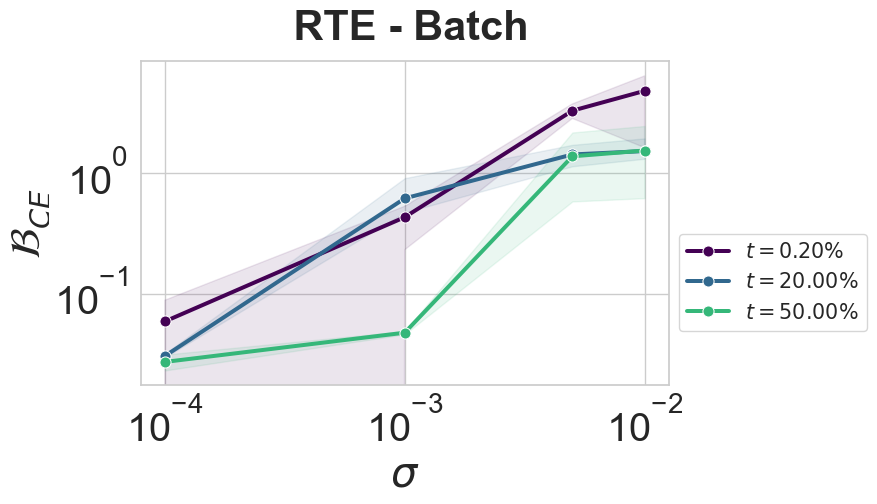

mrpc
38
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved figure to out/butterfly/finetune-rebuttal/mrpc-batch-lmc-0-1-loss-weighted-barrier.png


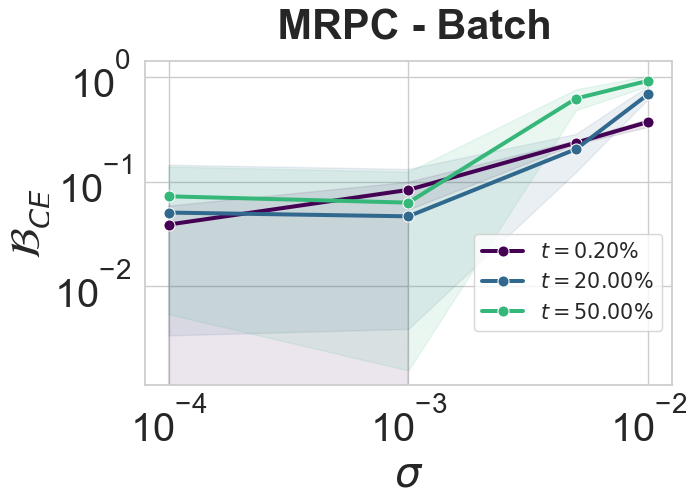

cola
32
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved figure to out/butterfly/finetune-rebuttal/cola-batch-lmc-0-1-loss-weighted-barrier.png


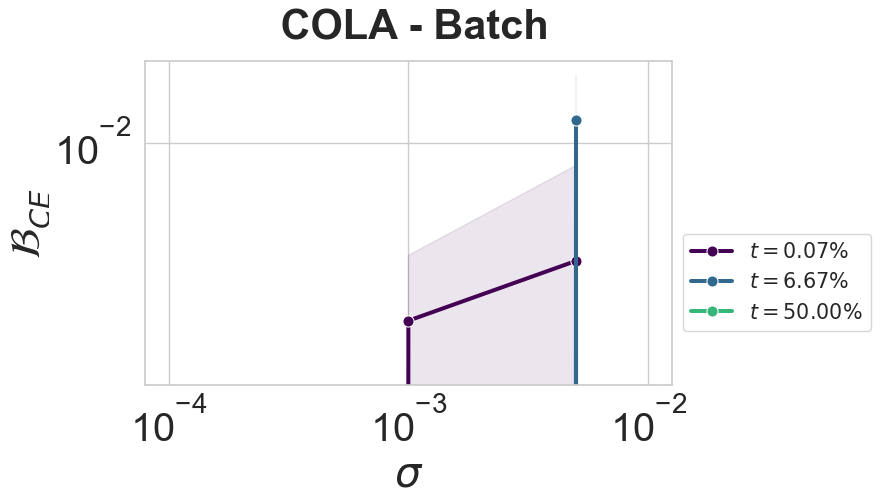

stsb
32
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved figure to out/butterfly/finetune-rebuttal/stsb-batch-lmc-0-1-loss-weighted-barrier.png


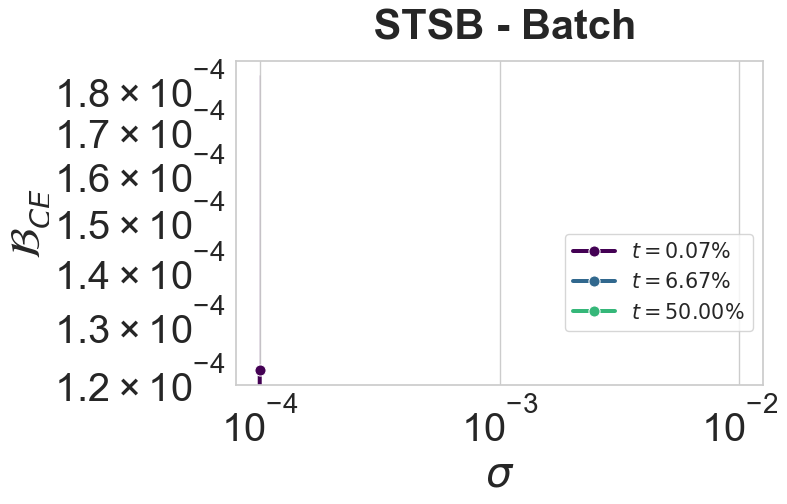

sst2
32
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved figure to out/butterfly/finetune-rebuttal/sst2-batch-lmc-0-1-loss-weighted-barrier.png


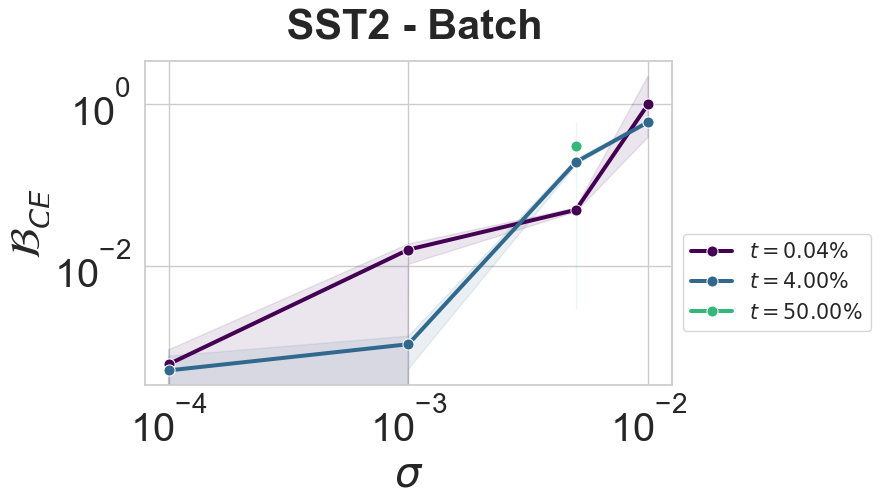

qnli
24
hello perturb_scale perturb_scale False
Saved figure to out/butterfly/finetune-rebuttal/qnli-batch-lmc-0-1-loss-weighted-barrier.png


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


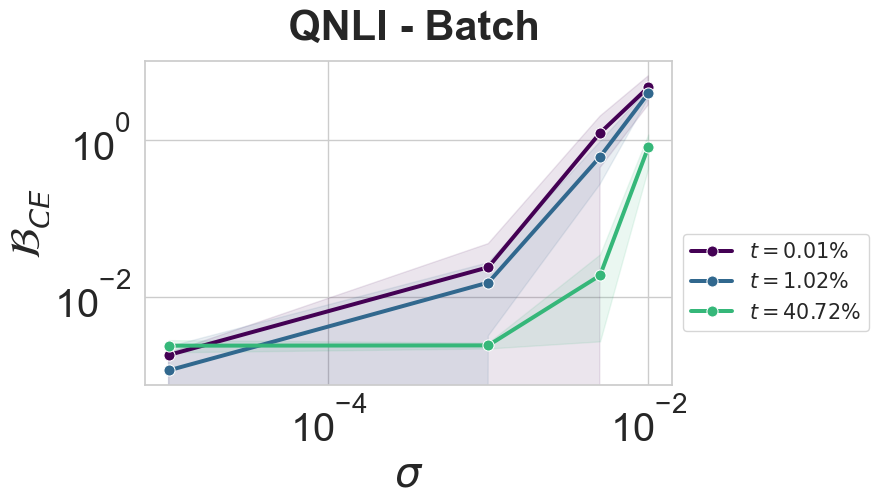

mnli
2
hello perturb_scale perturb_scale False
Saved figure to out/butterfly/finetune-rebuttal/mnli-batch-lmc-0-1-loss-weighted-barrier.png


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index
/Users/gsaltintas/code/thesis/clean/lmc/logging/plot.py:257: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  inset_ax.set_xlabel("")


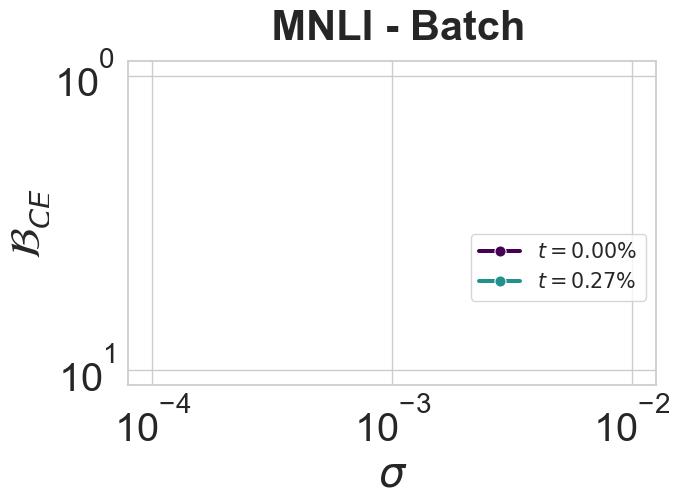

In [49]:
perturb_method = "batch"
for dataset in merged_df["data.dataset"].unique():
    print(dataset)

    group = dataset
    filters_ = (merged_df["data.dataset"] == dataset) & (
        merged_df["trainer.opt.warmup_ratio"] > 0
    )
    if True:
        # for perturb_step in merged_df[filters_]["perturb_step_relative"].unique():
        bert_ckpt = "2000k"
        # for ckpt in merged_df["bert_ckpt"].unique():
        filters = filters_ & (merged_df["bert_ckpt"] == bert_ckpt)
        # filters = filters_
        # group = f"{dataset}-{perturb_step}"
        # for perturb_method in merged_df[filters]["perturb_mode"].unique():
        # print(perturb_method)
        for base_prefix in ["lmc"]:
            # for base_prefix in ["lmc", "perm_wm"]:
            base_name = f"{base_prefix}_loss_train_0_1"
            zoom = None
            x_metric = "perturb_scale"
            legend_template = r"$t={:.2f}\%$"
            labels = ["perturb_step_relative"]
            # labels = ["bert_ckpt"]
            # labels=["bert_ckpt", "perturb_step_relative"]

            tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
            print(len(tmp))
            title = f" {dataset.upper()} - {perturb_method.title()}"
            t = plot_perturb_barrier(
                tmp,
                registry,
                perturb_method,
                base_name,
                zoom=zoom,
                filter_bad_runs=False,
                separate_legend=True,
                plot_type="line",
                title=title,
                x_metric=x_metric,
                labels=labels,
                legend_template=legend_template,
            legend_title="",
                # legend_title="Perturbed at",
                # hue_cnt=5,
                ncols=4,
                save_fig=True,
                xscale="log",
                save_prefix=group,
                out_dir=out,
                uncertainty=True,
            )

## All ckpt


47
hello perturb_scale perturb_scale False
Saved figure to out/butterfly/finetune-rebuttal/rte-first-half-batch-lmc-0-1-loss-weighted-barrier.png


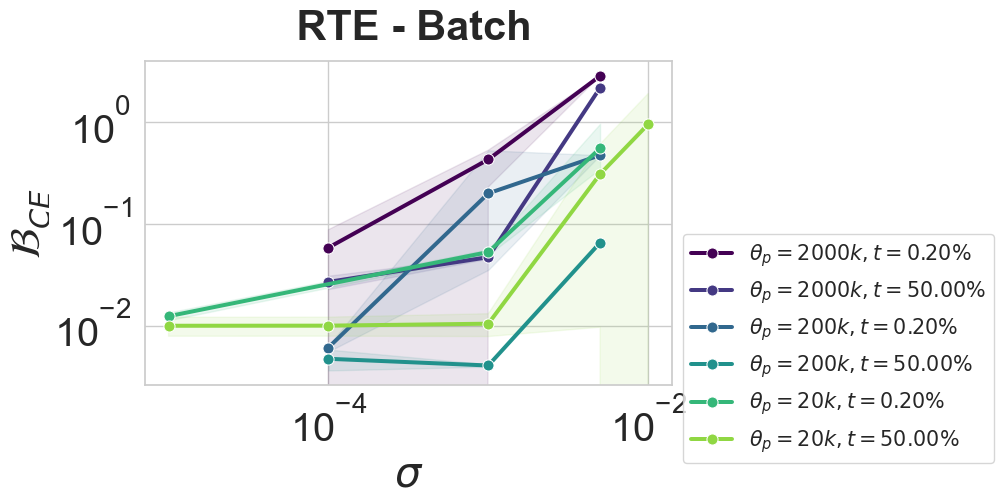

49
hello perturb_scale perturb_scale False
Saved figure to out/butterfly/finetune-rebuttal/mrpc-first-half-batch-lmc-0-1-loss-weighted-barrier.png


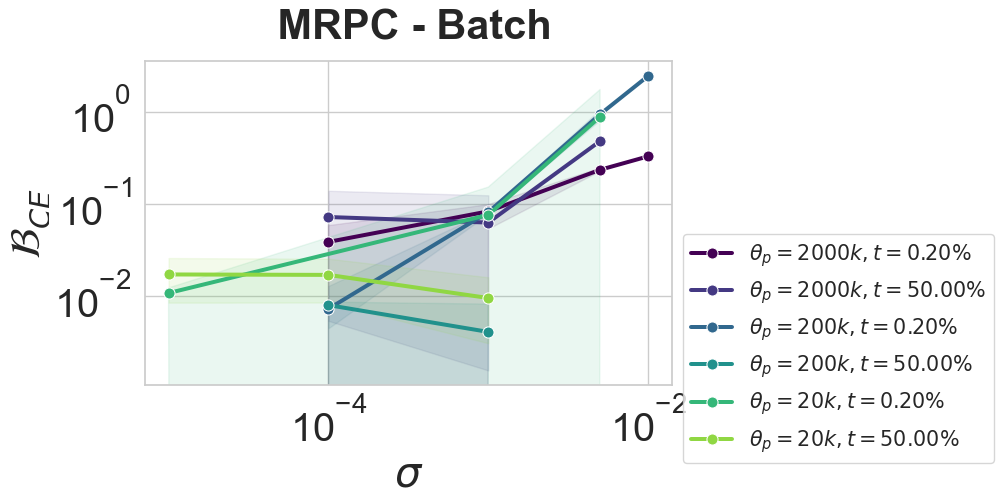

44
hello perturb_scale perturb_scale False
Saved figure to out/butterfly/finetune-rebuttal/cola-first-half-batch-lmc-0-1-loss-weighted-barrier.png


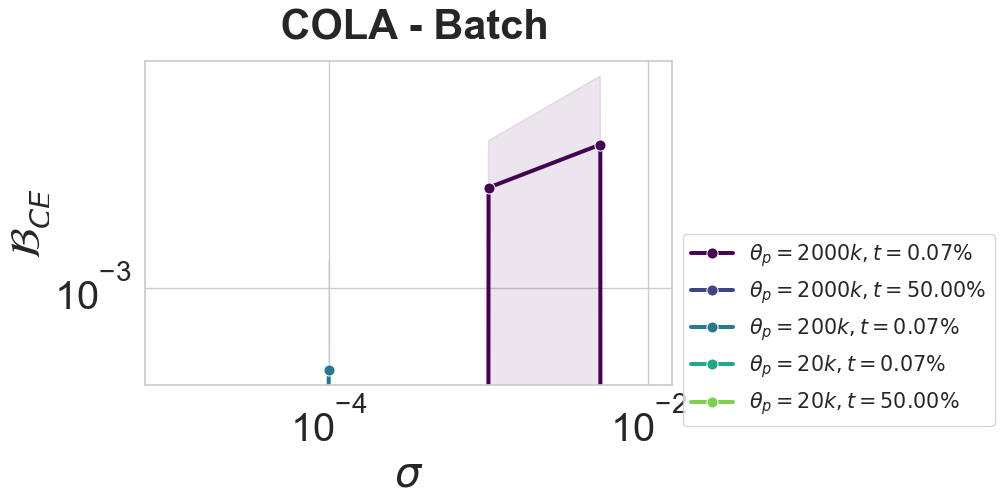

19
hello perturb_scale perturb_scale False
Saved figure to out/butterfly/finetune-rebuttal/stsb-first-half-batch-lmc-0-1-loss-weighted-barrier.png


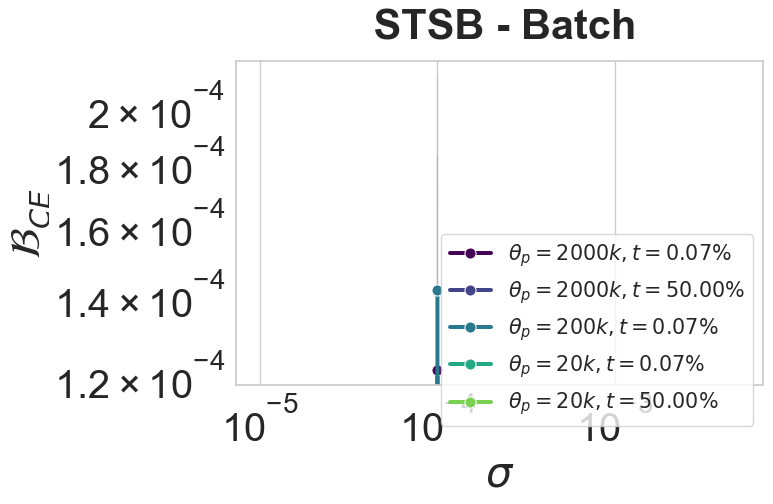

35
hello perturb_scale perturb_scale False
Saved figure to out/butterfly/finetune-rebuttal/sst2-first-half-batch-lmc-0-1-loss-weighted-barrier.png


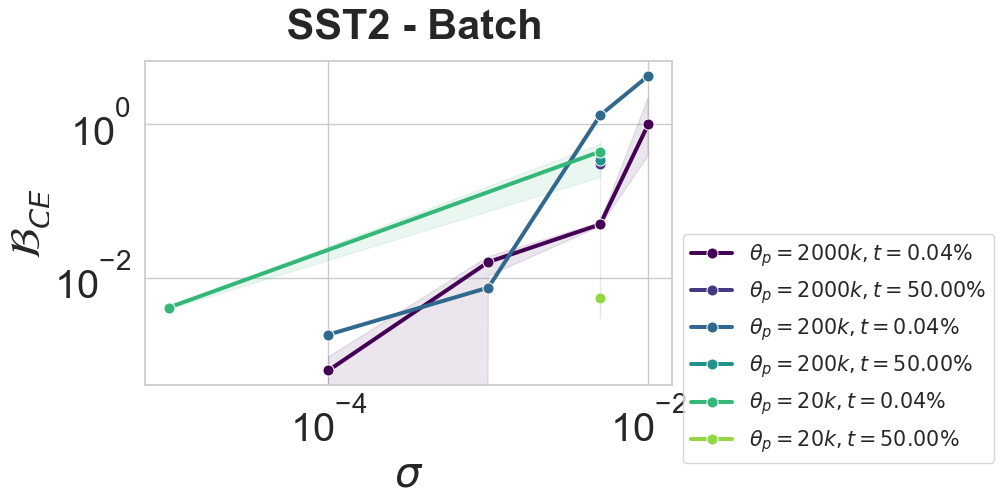

39
hello perturb_scale perturb_scale False
Saved figure to out/butterfly/finetune-rebuttal/qnli-first-half-batch-lmc-0-1-loss-weighted-barrier.png


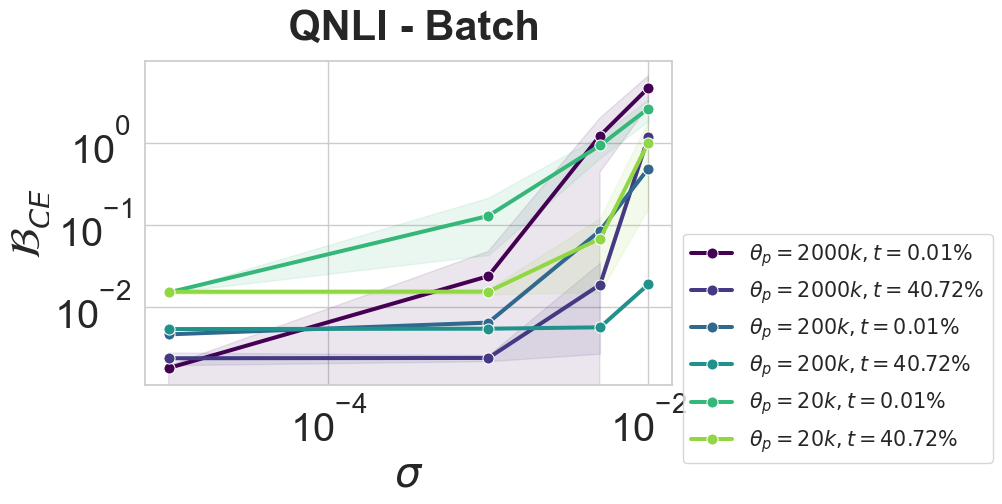

6
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/plot.py:257: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  inset_ax.set_xlabel("")


Saved figure to out/butterfly/finetune-rebuttal/mnli-first-half-batch-lmc-0-1-loss-weighted-barrier.png


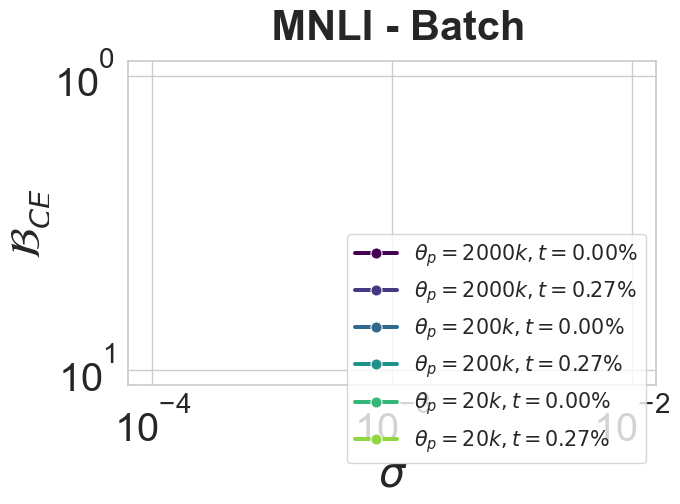

In [50]:
perturb_method = "batch"
perturb_thresh = 40
perturb_thresh = 100
for dataset in merged_df["data.dataset"].unique():
    group = dataset + ("-first-half" if perturb_thresh == 100 else "")
    filters_ = (
        (merged_df["data.dataset"] == dataset)
        & (merged_df["trainer.opt.warmup_ratio"] > 0)
        & (merged_df["model1.train.cross_entropy"] < 0.5)
        & (merged_df["model2.train.cross_entropy"] < 0.5)
    )
    if True:
        # for perturb_step in merged_df[filters_]["perturb_step_relative"].unique():
        # for ckpt in merged_df["bert_ckpt"].unique():
        filters = filters_ & (merged_df["perturb_step_relative"] < perturb_thresh)
        filters = filters_ & (
            (merged_df["perturb_step_relative"] < 1)
            | (merged_df["perturb_step_relative"] > 40)
        )
        # filters = filters_
        # group = f"{dataset}-{perturb_step}"
        # for perturb_method in merged_df[filters]["perturb_mode"].unique():
        # print(perturb_method)
        for base_prefix in ["lmc"]:
            # for base_prefix in ["lmc", "perm_wm"]:
            base_name = f"{base_prefix}_loss_train_0_1"
            zoom = None
            x_metric = "perturb_scale"
            legend_template = r"$\theta_p={}, t={:.2f}\%$"
            legend_title = "Spawning checkpoint, perturbed at"
            labels = ["perturb_step_relative"]
            labels = ["bert_ckpt"]
            labels = ["bert_ckpt", "perturb_step_relative"]
            labels = ["bert_ckpt", "perturb_step_relative"]

            tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
            print(len(tmp))
            title = f" {dataset.upper()} - {perturb_method.title()}"
            
            t = plot_perturb_barrier(
                tmp,
                registry,
                perturb_method,
                base_name,
                zoom=zoom,
                filter_bad_runs=False,
                separate_legend=True,
                plot_type="line",
                title=title,
                x_metric=x_metric,
                labels=labels,
                legend_template=legend_template,
                # legend_title=legend_title,
            legend_title="",

                # hue_cnt=5,
                ncols=3,
                save_fig=True,
                xscale="log",
                save_prefix=group,
                out_dir=out,
                uncertainty=True,
                inset_fig=False,
                inset_pos="left",
                zoom_first_step=0,
                zoom_last_step=0.001,
                zoom_y_last_step=0.2,
                yscale="linear",
                # yscale="log",
            )

In [49]:
# perturb_method = "batch"
# for dataset in merged_df["data.dataset"].unique():
#     group = dataset
#     for
#     # for ckpt in merged_df["bert_ckpt"].unique():
#         filters = (merged_df["data.dataset"] == dataset) & (merged_df["bert_ckpt"] == ckpt)
#         group = f"{dataset} - {group}"
#     # for perturb_method in merged_df[filters]["perturb_mode"].unique():
#         # print(perturb_method)
#         for base_prefix in ["lmc"]:
#         # for base_prefix in ["lmc", "perm_wm"]:
#             base_name = f"{base_prefix}_loss_train_0_1"
#             zoom = None
#             x_metric = "perturb_scale"
#             legend_template = r"$t={:.1f} \%$"
#             labels = ["perturb_step_relative"]

#             tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
#             print(len(tmp))
#             title = f" {dataset.title()} - {perturb_method}".title()
#             t = plot_perturb_barrier(
#                 tmp,
#                 registry,
#                 perturb_method,
#                 base_name,
#                 zoom=zoom,
#                 filter_bad_runs=False,
#                 separate_legend=True,
#                 plot_type="line",
#                 title=title,
#                 x_metric=x_metric,
#                 labels=labels,
#                 legend_template=legend_template,
#                 legend_title="Perturbed at",
#                 # hue_cnt=5,
#                 ncols=4,
#                 save_fig=True,
#                 xscale="log",
#                 save_prefix=group,
#                 out_dir=out,
#             )

In [301]:
merged_df[
    (merged_df["data.dataset"] == "rte")
    & (merged_df["trainer.opt.warmup_ratio"] > 0)
    & (merged_df["perturb_mode"] == "batch")
]["bert_ckpt"]

merged_df["bert_ckpt"].unique()


array(['2000k', '20k', '200k'], dtype=object)

## Perf vs Barr

137
hello test_accuracy_2 test_accuracy_2 True
WandbMetric(log_name='model2/test/accuracy', ylabel='$\\mathrm{Acc}^{2}_{\\mathrm{Te}}$', prefix='model2-acc', category=<MetricCategory.ACCURACY: 'accuracy'>, split=<Split.TEST: 'test'>, general_ylabel='$\\mathrm{Acc}^{2}_{\\mathrm{}}$', flat_name='model2.test.accuracy') model2.test.accuracy None
None


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


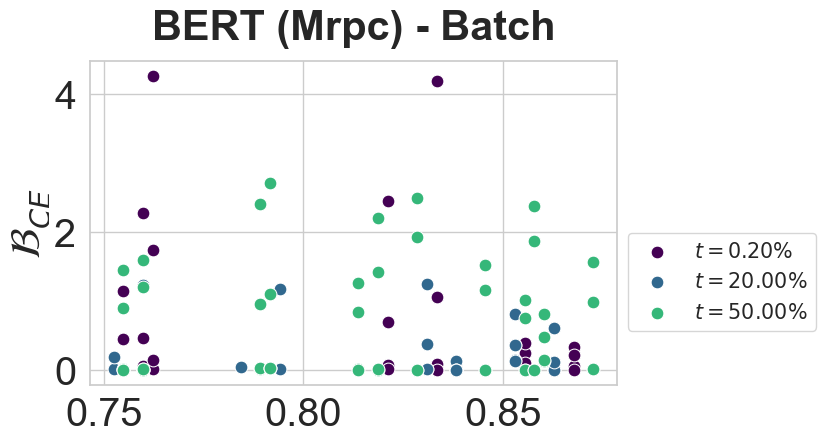

In [189]:
perturb_method = "batch"

group = dataset
dataset = "Cifar100"
dataset = "qnli"
dataset = "mrpc"
filters_ = (
    (merged_df["data.dataset"] == dataset.lower()) &
    # (merged_df["trainer.opt.warmup_ratio"] > 0)
    # & (merged_df["perturb_step"] > 0)
    # & (merged_df["model2.train.accuracy"] > 0.9)
    # & (merged_df["model1.train.accuracy"] > 0.9)
    ~(merged_df["run.group"] == "rand-labels")
    & ~(merged_df["bert_ckpt"].isna())
    & (merged_df["model1.test.accuracy"] != "null")
    & (merged_df["model2.test.accuracy"] != "null")
    # & (merged_df["model2.train.cross_entropy"] < 0.4)
    # & (merged_df["model1.train.cross_entropy"] < 0.4)
)
if True:
# for bert_ckpt in merged_df["bert_ckpt"].unique():
    # for ckpt in merged_df["bert_ckpt"].unique():
    # filters = filters_ & (merged_df["bert_ckpt"] == bert_ckpt)
    filters = filters_
    for base_prefix in ["lmc"]:
    # for base_prefix in ["lmc", "perm_wm"]:
        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "perturb_scale"
        legend_template = r"$t={:.2f}\%$"
        labels = ["perturb_step_relative"]
        # labels = ["bert_ckpt"]
        # labels=["bert_ckpt", "perturb_step_relative"]
        x_metric = f"test_accuracy_2"
        xscale="linear"

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
        tmp = tmp[(tmp["model1.test.accuracy"] >= 0.6)]
        
        print(len(tmp))
        title = f"{bert_ckpt} to {dataset.upper()} - {perturb_method.title()}"
        title = f"BERT ({dataset.capitalize()}) - {perturb_method.title()}"
        
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=False,
            # separate_legend=True,
            plot_type="scatter",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
        legend_title="",
            # legend_title="Perturbed at",
            # hue_cnt=5,
            ncols=4,
            save_fig=False,
            xscale=xscale,
            yscale="linear",
            out_dir=out,
            uncertainty=True,
            file_extension="png",
            save_prefix=f"vit-{group}"
        )

## Multibert L2 Fixed etc


batch 80
hello l2_dist_1-2 l2_dist_1-2 True


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier.pdf


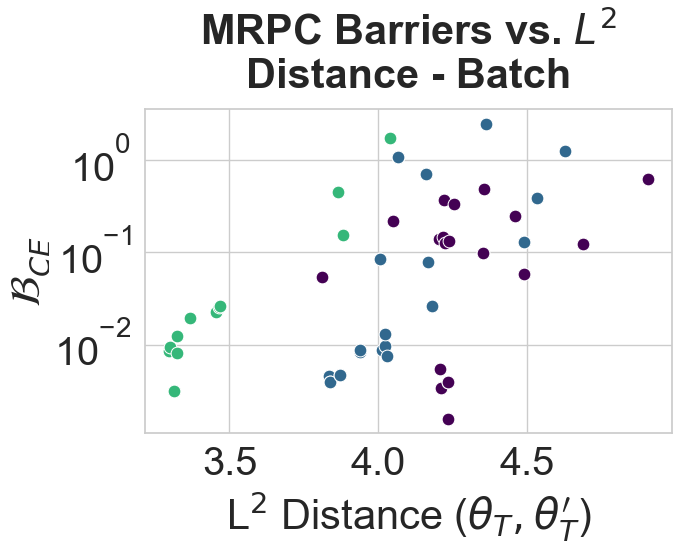

<Figure size 680.78x420.745 with 0 Axes>

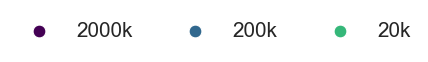

batch 75
hello l2_dist_1-2 l2_dist_1-2 True


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier.pdf


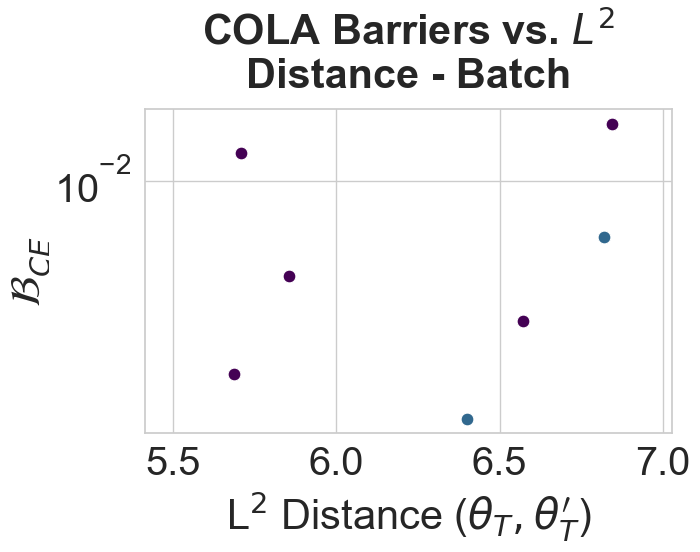

<Figure size 680.78x420.745 with 0 Axes>

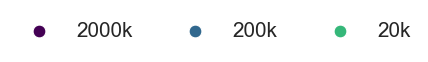

batch 63
hello l2_dist_1-2 l2_dist_1-2 True


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier.pdf


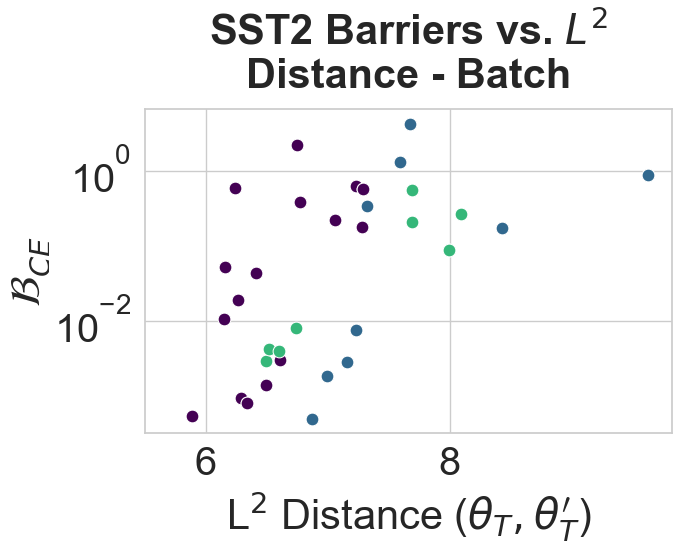

<Figure size 680.78x420.745 with 0 Axes>

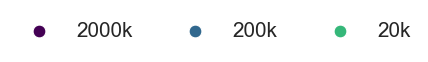

batch 58
hello l2_dist_1-2 l2_dist_1-2 True


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier.pdf


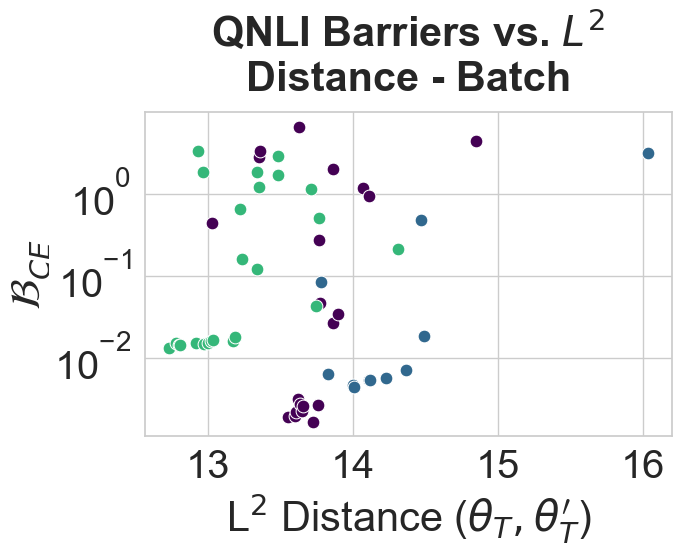

<Figure size 680.78x420.745 with 0 Axes>

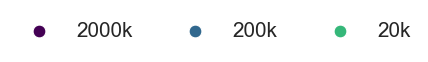

batch 65
hello l2_dist_1-2 l2_dist_1-2 True
Saved legend to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier.pdf


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


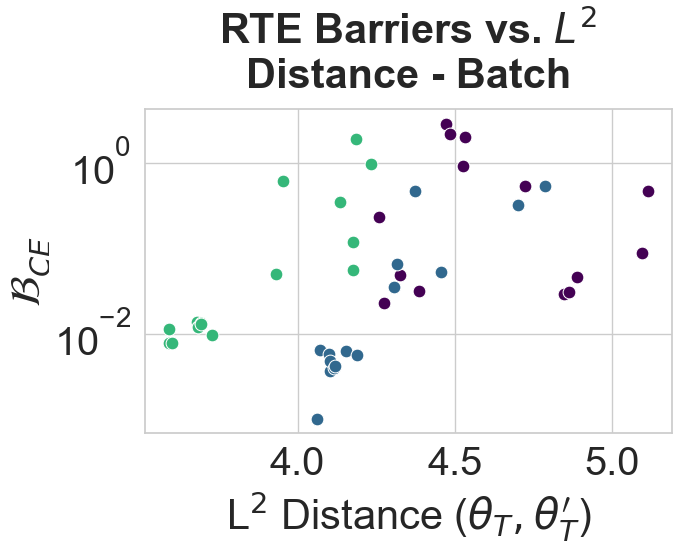

<Figure size 680.78x420.745 with 0 Axes>

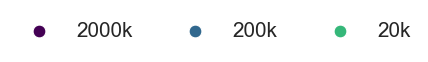

In [50]:
# group = "standard-sanity"
# filters = merged_df["run.group"] == group
datasets = ["mrpc", "cola", "sst2", "qnli", "rte"]
filters = (
    (~merged_df["pretty_group"].isna())
    &(merged_df[registry.get_metric("l2_dist_1-2").flat_name] != "null")
    & (merged_df["trainer.opt.warmup_ratio"] > 0)
    & (merged_df["model1.train.cross_entropy"] < 0.5)
    & (merged_df["model2.train.cross_entropy"] < 0.5)
    &(merged_df["data.dataset"].isin(["mrpc", "cola", "sst2", "qnli", "rte"]))
    &(merged_df["seeds.loader_seed1"] ==merged_df["seeds.loader_seed2"])
)

for dataset in datasets:
    perturb_method = "batch"
    base_prefix="lmc"
    if True:
# for perturb_method in ["batch", "gaussian"]:
#     for base_prefix in ["lmc", "perm_wm"]:

        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        legend_template = "{}"
        labels = ["bert_ckpt"]
        x_metric = "l2_dist_1-2"
        # labels = ["data.dataset"]
        # # labels=["perturb_step_relative"]
        # labels=["pretty_group"]

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method) 
                        &(merged_df["data.dataset"] == dataset)]
        print(perturb_method, len(tmp))
        title = f"{dataset.upper()} Barriers vs. $L^2$ Distance - {perturb_method.title()}"
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=True,
            plot_type="scatter",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
            legend_title="",
            # legend_title="Setting",
            # hue_cnt=6,
            ncols=3,
            save_fig=True,
            # xscale="log",
            yscale="log",
            save_prefix=f"l2-barr-group-{group}",
            out_dir=out.joinpath("scatter"),
            zoom_first_step=0,
            zoom_last_step=0.05,
            uncertainty=False,
            inset_fig=False,
            inset_pos="right",
            zoom_y_last_step=0.3,
            x_label=r"L$^2$ Distance ($\theta_T, \theta_T^\prime$)",
        )

### Fixed Pts

batch 80
hello perm_wm_fixed_ponts_1_2 perm_wm_fixed_ponts_1_2 True


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier.pdf


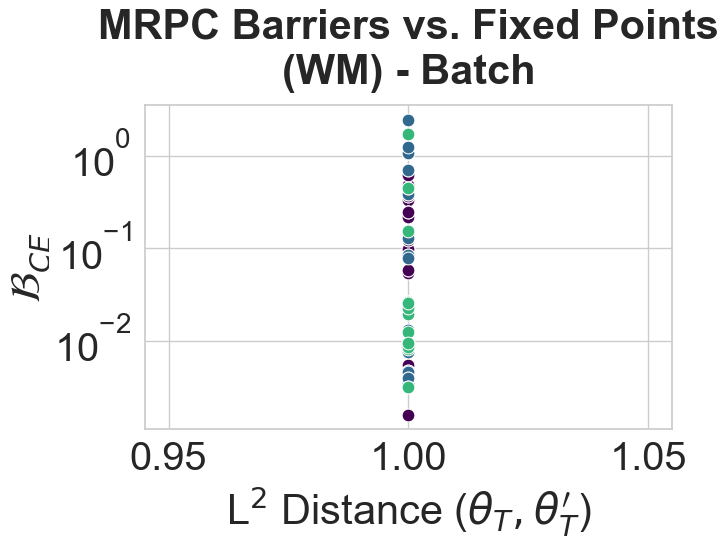

<Figure size 680.78x420.745 with 0 Axes>

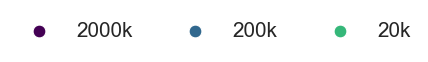

batch 75
hello perm_wm_fixed_ponts_1_2 perm_wm_fixed_ponts_1_2 True
Saved legend to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier.pdf


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


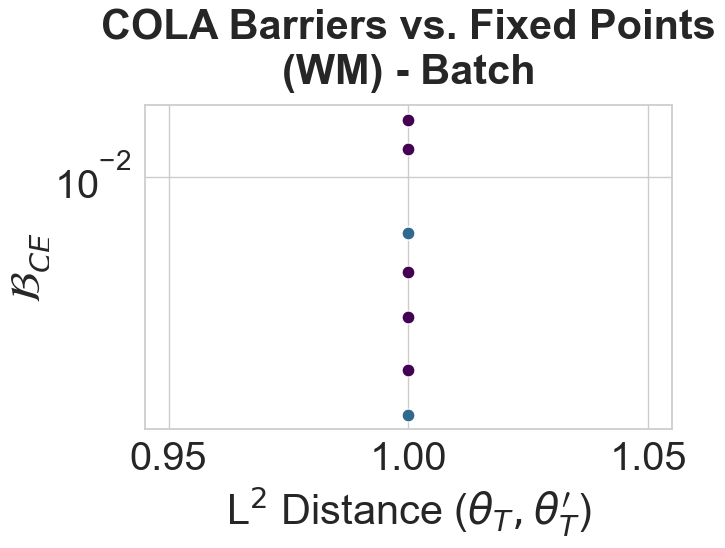

<Figure size 680.78x420.745 with 0 Axes>

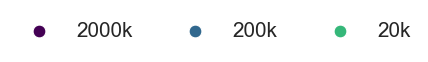

batch 63
hello perm_wm_fixed_ponts_1_2 perm_wm_fixed_ponts_1_2 True
Saved legend to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier.pdf


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


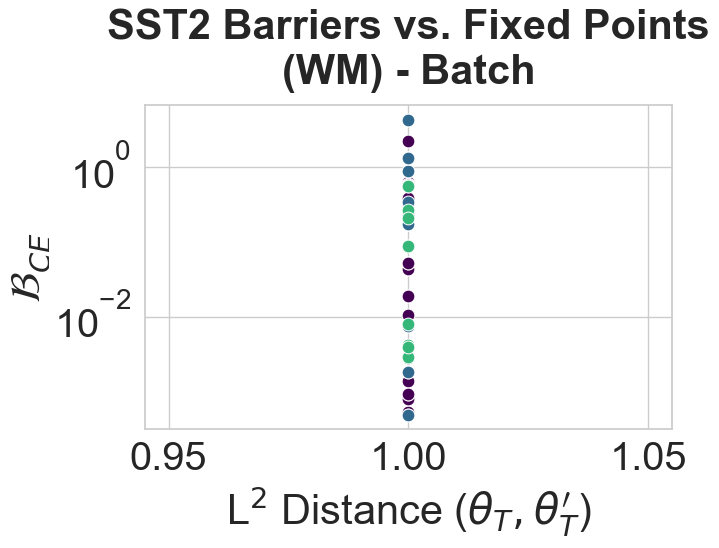

<Figure size 680.78x420.745 with 0 Axes>

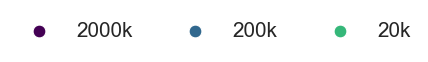

batch 58
hello perm_wm_fixed_ponts_1_2 perm_wm_fixed_ponts_1_2 True


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier.pdf


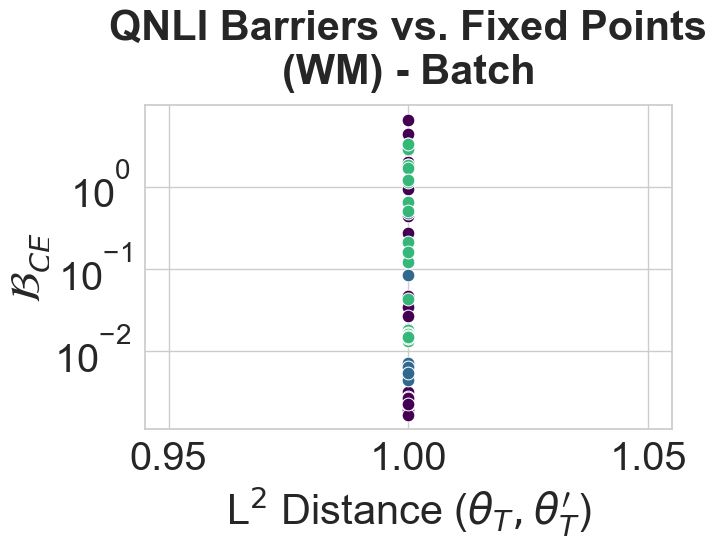

<Figure size 680.78x420.745 with 0 Axes>

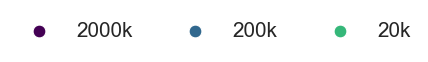

batch 65
hello perm_wm_fixed_ponts_1_2 perm_wm_fixed_ponts_1_2 True
Saved legend to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/finetuning/multibert/scatter/l2-barr-group-mnli-first-half-batch-lmc-0-1-loss-weighted-barrier.pdf


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


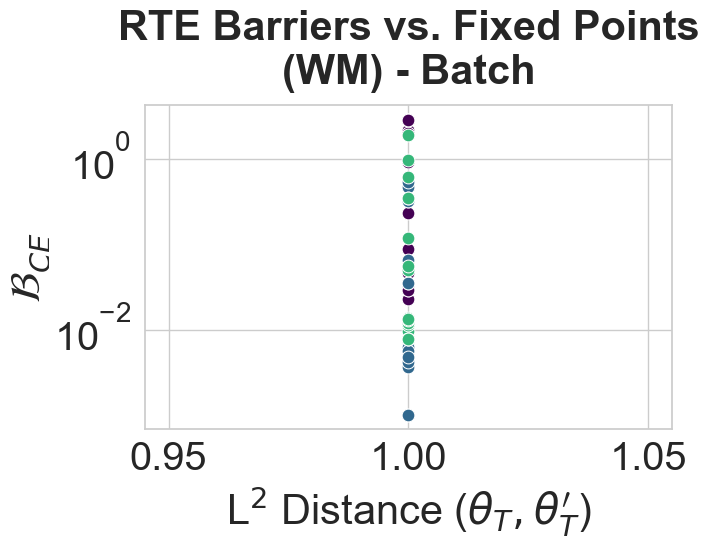

<Figure size 680.78x420.745 with 0 Axes>

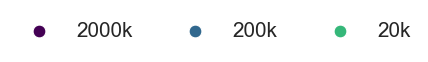

In [51]:
# group = "standard-sanity"
# filters = merged_df["run.group"] == group
datasets = ["mrpc", "cola", "sst2", "qnli", "rte"]
filters = (
    (~merged_df["pretty_group"].isna())
    &(merged_df[registry.get_metric("l2_dist_1-2").flat_name] != "null")
    & (merged_df["trainer.opt.warmup_ratio"] > 0)
    & (merged_df["model1.train.cross_entropy"] < 0.5)
    & (merged_df["model2.train.cross_entropy"] < 0.5)
    &(merged_df["data.dataset"].isin(["mrpc", "cola", "sst2", "qnli", "rte"]))
    &(merged_df["seeds.loader_seed1"] ==merged_df["seeds.loader_seed2"])
)

for dataset in datasets:
    perturb_method = "batch"
    base_prefix="lmc"
    if True:
# for perturb_method in ["batch", "gaussian"]:
#     for base_prefix in ["lmc", "perm_wm"]:

        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        legend_template = "{}"
        labels = ["bert_ckpt"]
        x_metric = "l2_dist_1-2"
        x_metric = "perm_wm_fixed_ponts_1_2"
        # labels = ["data.dataset"]
        # # labels=["perturb_step_relative"]
        # labels=["pretty_group"]

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method) 
                        &(merged_df["data.dataset"] == dataset)]
        print(perturb_method, len(tmp))
        title = f"{dataset.upper()} Barriers vs. Fixed Points (WM) - {perturb_method.title()}"
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=True,
            plot_type="scatter",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
            legend_title="",
            # legend_title="Setting",
            # hue_cnt=6,
            ncols=3,
            save_fig=True,
            # xscale="log",
            yscale="log",
            save_prefix=f"l2-barr-group-{group}",
            out_dir=out.joinpath("scatter"),
            zoom_first_step=0,
            zoom_last_step=0.05,
            uncertainty=False,
            inset_fig=False,
            inset_pos="right",
            zoom_y_last_step=0.3,
            x_label=r"L$^2$ Distance ($\theta_T, \theta_T^\prime$)",
        )

batch 80
hello l2_dist_1-2 l2_dist_1-2 True


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/finetuning/multibert/scatter/l2-barr-mrpc-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/finetuning/multibert/scatter/l2-barr-mrpc-batch-lmc-0-1-loss-weighted-barrier.pdf


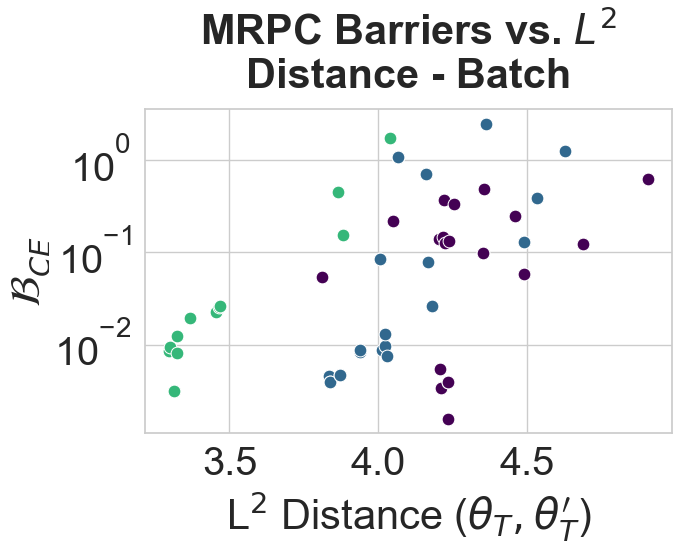

<Figure size 680.78x420.745 with 0 Axes>

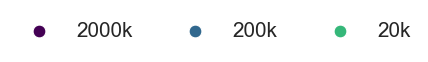

batch 75
hello l2_dist_1-2 l2_dist_1-2 True


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/finetuning/multibert/scatter/l2-barr-cola-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/finetuning/multibert/scatter/l2-barr-cola-batch-lmc-0-1-loss-weighted-barrier.pdf


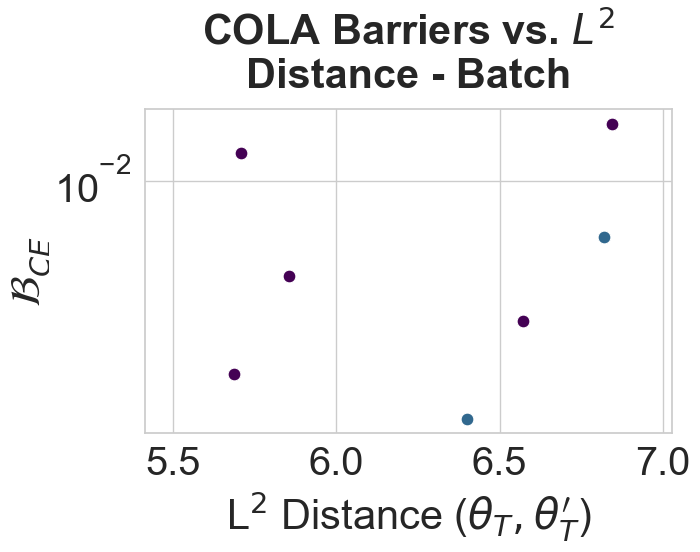

<Figure size 680.78x420.745 with 0 Axes>

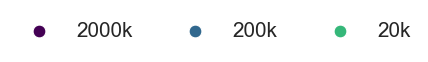

batch 63
hello l2_dist_1-2 l2_dist_1-2 True


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/finetuning/multibert/scatter/l2-barr-sst2-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/finetuning/multibert/scatter/l2-barr-sst2-batch-lmc-0-1-loss-weighted-barrier.pdf


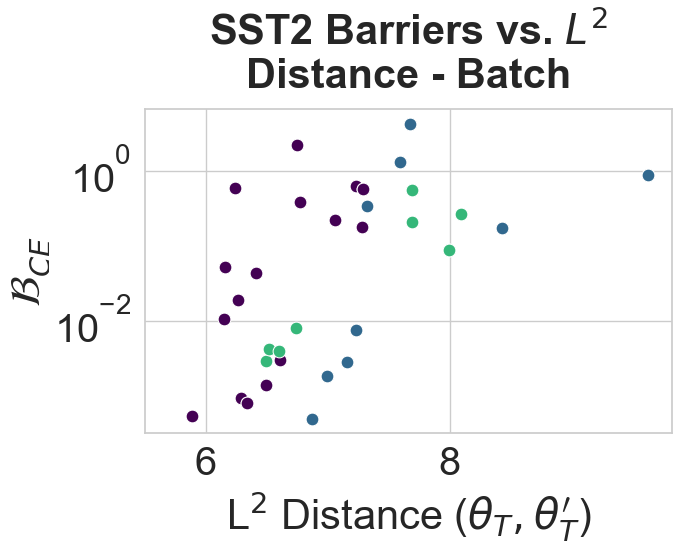

<Figure size 680.78x420.745 with 0 Axes>

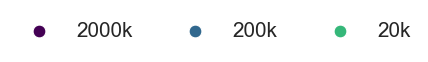

batch 58
hello l2_dist_1-2 l2_dist_1-2 True


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/finetuning/multibert/scatter/l2-barr-qnli-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/finetuning/multibert/scatter/l2-barr-qnli-batch-lmc-0-1-loss-weighted-barrier.pdf


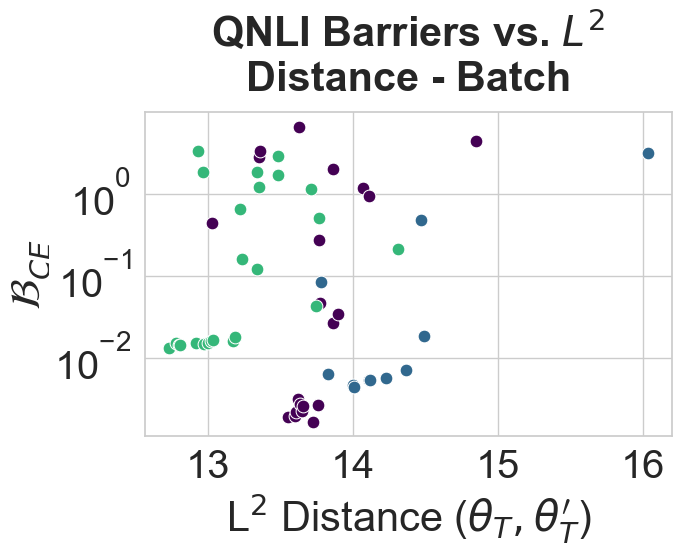

<Figure size 680.78x420.745 with 0 Axes>

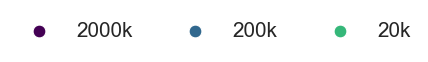

batch 65
hello l2_dist_1-2 l2_dist_1-2 True
Saved legend to out/finetuning/multibert/scatter/l2-barr-rte-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/finetuning/multibert/scatter/l2-barr-rte-batch-lmc-0-1-loss-weighted-barrier.pdf


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


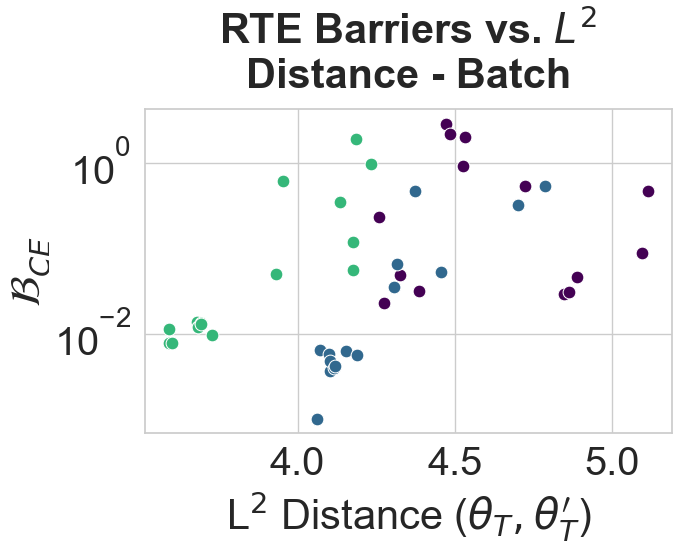

<Figure size 680.78x420.745 with 0 Axes>

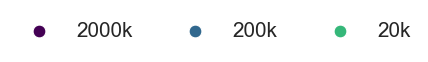

In [55]:
# group = "standard-sanity"
# filters = merged_df["run.group"] == group
datasets = ["mrpc", "cola", "sst2", "qnli", "rte"]
filters = (
    (~merged_df["pretty_group"].isna())
    &(merged_df[registry.get_metric("l2_dist_1-2").flat_name] != "null")
    & (merged_df["trainer.opt.warmup_ratio"] > 0)
    & (merged_df["model1.train.cross_entropy"] < 0.5)
    & (merged_df["model2.train.cross_entropy"] < 0.5)
    &(merged_df["data.dataset"].isin(["mrpc", "cola", "sst2", "qnli", "rte"]))
    &(merged_df["seeds.loader_seed1"] ==merged_df["seeds.loader_seed2"])
)

for dataset in datasets:
    perturb_method = "batch"
    base_prefix="lmc"
    if True:
# for perturb_method in ["batch", "gaussian"]:
#     for base_prefix in ["lmc", "perm_wm"]:

        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "l2_dist_1-2"
        legend_template = "{}"
        labels = ["bert_ckpt"]
        # labels = ["data.dataset"]
        # # labels=["perturb_step_relative"]
        # labels=["pretty_group"]

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method) 
                        &(merged_df["data.dataset"] == dataset)]
        print(perturb_method, len(tmp))
        title = f"{dataset.upper()} Barriers vs. $L^2$ Distance - {perturb_method.title()}"
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=True,
            plot_type="scatter",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
            legend_title="",
            # legend_title="Setting",
            # hue_cnt=6,
            ncols=3,
            save_fig=True,
            # xscale="log",
            yscale="log",
            save_prefix=f"l2-barr-{dataset}",
            out_dir=out.joinpath("scatter"),
            zoom_first_step=0,
            zoom_last_step=0.05,
            uncertainty=False,
            inset_fig=False,
            inset_pos="right",
            zoom_y_last_step=0.3,
            x_label=r"L$^2$ Distance ($\theta_T, \theta_T^\prime$)",
        )

In [53]:
tmp["l2.dist_1-2"].describe()

count     65.000000
unique    48.000000
top        4.373541
freq       4.000000
Name: l2.dist_1-2, dtype: float64

# Cifar10-old


In [209]:
api = wandb.Api()
out = Path("out/cifar10-from-100-pretrain")
out.mkdir(exist_ok=True, parents=True)

project_path = "gsaltintas/LMCPretrainingStability"
runs = api.runs(
    project_path,
    filters={
        "tags": {"$nin": ["ignore", "delete"]},
        "config.data.dataset": {"$in": ["cifar10"]},
    },
)

len(runs)

381

In [210]:
main_df, registry = get_merged_df(
    runs,
    scale_barriers=False,
    performance_aware=False,
    find_missing=False,
    return_registry=True,
)
main_df["bert_ckpt"] = (
    main_df["model.ckpt_path"].str.split("/").str[-1].str.split(".").str[0]
)
# main_df[registry.get_metric("noise_l2_scaled_1").flatname]
# main_df[registry.get_metric("noise_l2_scaled_2").flat_name]

na_filters = (
    (main_df["model1.test.accuracy"] != "null")
    & (main_df["model1.train.cross_entropy"] != "NaN")
    & (~main_df["model1.train.cross_entropy"].isna())
    & (~main_df["model2.train.cross_entropy"].isna())
    & (~main_df[registry.get_metric("lmc_loss_train_0_1").flat_name].isna())
    & (~main_df["bert_ckpt"].isna())
    & (main_df["n_models"] == 2)
)

merged_df = main_df[na_filters]

# further_filters = (
#      (merged_df["trainer.opt.lr"] == 0.1)
#     & check_nulls(merged_df, wandb_keys.get_metric("lmc_loss_train_0_1").flat_name)
#     & (merged_df["average_test_acc"] >= 0.7)
#     & (merged_df["model2.test.accuracy"] >= 0.8)
#     & (merged_df["epoch"] >= 50)
# )

print(len(merged_df))

/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["trainer.opt.warmup_ratio"].fillna(0, inplace=True)
/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:170: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'null' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.fillna("null", inplace=True)


156


hello perturb_scale perturb_scale False
Saved legend to outputs/gaussian-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to outputs/gaussian-lmc-0-1-loss-weighted-barrier.pdf


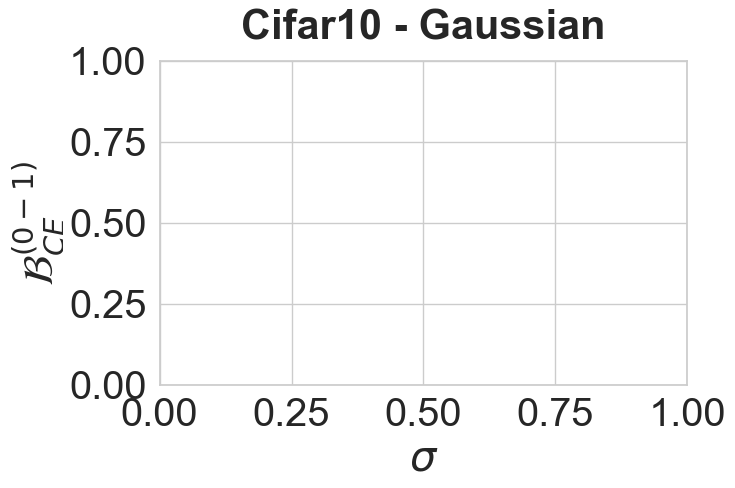

<Figure size 680.78x420.745 with 0 Axes>

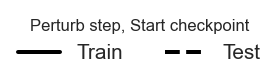

In [211]:
from lmc.logging.plot import plot_perturb_barrier

perturb_method = "batch"
perturb_method = "gaussian"
base_name = "lmc_train_0_1"
base_name = "lmc_loss_train_0_1"
zoom = "first"
zoom = None
# zoom = "last"
title = f"{perturb_method} - No perturb bias and norm".title()
title = f"{perturb_method} - Perturb all".title()
x_metric = "perturb_scale"
labels = [
    "bert_ckpt",
    "perturb_step",
]
legend_template = r"$t={}, {}$"

for dataset in merged_df["data.dataset"].unique():
    tmp = merged_df[merged_df["data.dataset"] == "dataset"]
    # tmp = merged_df[(merged_df["data.dataset"] == dataset)&(merged_df["trainer.opt.warmup_ratio"]>0)]
    title = f"{dataset.upper()} - {perturb_method}".title()
    t = plot_perturb_barrier(
        tmp,
        registry,
        perturb_method,
        base_name,
        zoom=zoom,
        filter_bad_runs=False,
        separate_legend=True,
        plot_type="line",
        title=title,
        x_metric=x_metric,
        labels=labels,
        legend_template=legend_template,
        legend_title="Perturb step, Start checkpoint",
    )

# Cifar-10


In [212]:
api = wandb.Api()
out = Path("out/cifar10-0-pretrain")
out.mkdir(exist_ok=True, parents=True)

project_path = "gsaltintas/LMCPretrainingStability"
runs = api.runs(
    project_path,
    filters={
        "tags": {"$nin": ["ignore", "delete"]},
        "config.data.dataset": {"$in": ["cifar10"]},
    },
)

len(runs)

381

In [39]:
(~main_df["n_models"] != 3).sum()
main_df["n_models"] == 3

0      False
1      False
2      False
3      False
4      False
       ...  
264     True
265     True
266     True
267     True
268     True
Name: n_models, Length: 269, dtype: bool

In [40]:
main_df, registry = get_merged_df(
    runs,
    scale_barriers=False,
    performance_aware=False,
    find_missing=False,
    return_registry=True,
)
main_df["bert_ckpt"] = (
    main_df["model.ckpt_path"].str.split("/").str[-1].str.split(".").str[0]
)
# main_df[registry.get_metric("noise_l2_scaled_1").flatname]
# main_df[registry.get_metric("noise_l2_scaled_2").flat_name]

na_filters = (
    (main_df["model1.test.accuracy"] != "null")
    & (main_df["model1.train.cross_entropy"] != "NaN")
    & (~main_df["model1.train.cross_entropy"].isna())
    & (~main_df["model2.train.cross_entropy"].isna())
    & (~main_df[registry.get_metric("lmc_loss_train_0_1").flat_name].isna())
    & (~main_df["bert_ckpt"].isna())
    & (main_df["n_models"] == 2)
)

merged_df = main_df[na_filters]

# further_filters = (
#      (merged_df["trainer.opt.lr"] == 0.1)
#     & check_nulls(merged_df, wandb_keys.get_metric("lmc_loss_train_0_1").flat_name)
#     & (merged_df["average_test_acc"] >= 0.7)
#     & (merged_df["model2.test.accuracy"] >= 0.8)
#     & (merged_df["epoch"] >= 50)
# )

print(len(merged_df))

80


/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["trainer.opt.warmup_ratio"].fillna(0, inplace=True)
/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:170: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'null' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.fillna("null", inplace=True)


hello noise_l2_scaled_2 noise_l2_scaled_2 True
('0ep180st', 1)
('0ep180st', 100)
('0ep180st', 2000)
('191ep319st', 1)
('191ep319st', 100)
('191ep319st', 2000)
('3ep327st', 1)
('3ep327st', 100)
('3ep327st', 2000)
('57ep213st', 1)
('57ep213st', 100)
('57ep213st', 2000)


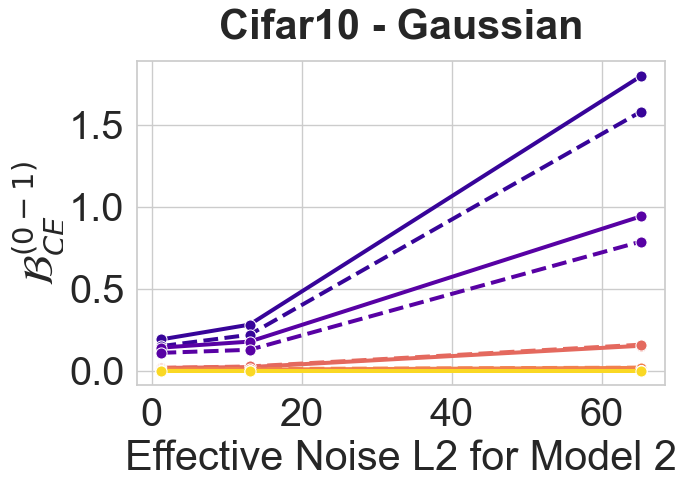

<Figure size 680.78x420.745 with 0 Axes>

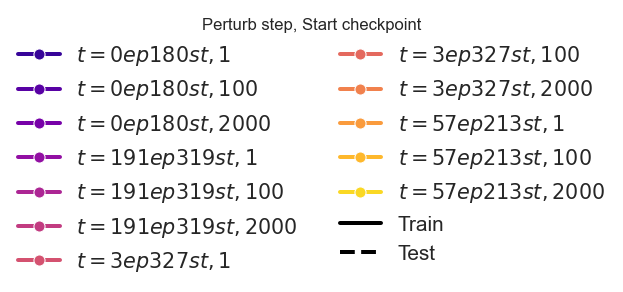

In [44]:
from lmc.logging.plot import plot_perturb_barrier

perturb_method = "batch"
perturb_method = "gaussian"
base_name = "lmc_train_0_1"
base_name = "lmc_loss_train_0_1"
zoom = "first"
zoom = None
# zoom = "last"
title = f"{perturb_method} - No perturb bias and norm".title()
title = f"{perturb_method} - Perturb all".title()
x_metric = "noise_l2_scaled_2"
labels = [
    "bert_ckpt",
    "perturb_step",
]
legend_template = r"$t={}, {}$"

for dataset in merged_df["data.dataset"].unique():
    tmp = merged_df
    # tmp = merged_df[(merged_df["data.dataset"] == dataset)&(merged_df["trainer.opt.warmup_ratio"]>0)]
    title = f"{dataset.upper()} - {perturb_method}".title()
    t = plot_perturb_barrier(
        tmp,
        registry,
        perturb_method,
        base_name,
        zoom=zoom,
        filter_bad_runs=False,
        separate_legend=True,
        plot_type="line",
        title=title,
        x_metric=x_metric,
        labels=labels,
        legend_template=legend_template,
        legend_title="Perturb step, Start checkpoint",
    )

In [13]:
merged_df["static.noise_l2.1.total"]

0           null
1           null
2           null
3           null
4           null
         ...    
258    65.276337
259     1.305527
260     1.305527
261    65.276337
262    13.055268
Name: static.noise_l2.1.total, Length: 175, dtype: object

# Multibert Tables


In [142]:
api.flush()
out = Path("out/finetuning/multibert")
out.mkdir(exist_ok=True, parents=True)

project_path = "gsaltintas/LMCPretrainingStability-MultiBert-2"
runs = api.runs(
    project_path,
    filters={
        "tags": {"$nin": ["ignore", "delete"]},
        "config.data.dataset": {"$nin": ["cifar10"]},
    },
)
len(runs)

1392

In [143]:
main_df, registry = get_merged_df(
    runs,
    scale_barriers=False,
    performance_aware=False,
    find_missing=False,
    return_registry=True,
)
main_df["bert_ckpt"] = main_df["model.model_name"].str.split("step_").str[1]

na_filters = (
    (main_df["model1.test.accuracy"] != "null")
    & (main_df["model1.train.cross_entropy"] != "NaN")
    & (~main_df["model1.train.cross_entropy"].isna())
    & (~main_df["model2.train.cross_entropy"].isna())
    & (~main_df[registry.get_metric("lmc_loss_train_0_1").flat_name].isna())
    & (~main_df["bert_ckpt"].isna())
)

merged_df = main_df[na_filters]

merged_df["steps_"] = merged_df.apply(get_steps, axis=1)
merged_df["perturb_step_log"] = merged_df["perturb_step"].apply(np.log)
merged_df["perturb_step_relative"] = merged_df.apply(
    lambda row: row["perturb_step"] / float(row["steps_"]) * 100, axis=1
)
# Combine filters and apply them in one step
# merged_df = merged_df.apply(rename_opt_lr, axis=1)
# code_name = merged_df["run.group"].apply(extract_model_name).apply(correct_cases).rename("code_name")
# Calculate mean and use pd.concat for efficiency
average_test_acc = (
    merged_df[["model1.test.accuracy", "model2.test.accuracy"]].mean(axis=1) * 100
).rename("average_test_acc")
average_train_acc = (
    merged_df[["model1.train.accuracy", "model2.train.accuracy"]].mean(axis=1) * 100
).rename("average_train_acc")
merged_df = pd.concat([merged_df, average_test_acc, average_train_acc], axis=1)
merged_df.loc[merged_df["perturb_step"] == -1, "perturb_step"] = 0

# further_filters = (
#      (merged_df["trainer.opt.lr"] == 0.1)
#     & check_nulls(merged_df, wandb_keys.get_metric("lmc_loss_train_0_1").flat_name)
#     & (merged_df["average_test_acc"] >= 0.7)
#     & (merged_df["model2.test.accuracy"] >= 0.8)
#     & (merged_df["epoch"] >= 50)
# )

len(merged_df)

/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["trainer.opt.warmup_ratio"].fillna(0, inplace=True)
/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:170: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'null' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.fillna("null", inplace=True)
/var/folders/8n/l2sy_xn

577

## Zero-Shot Perf


In [241]:
group_ind = ["data.dataset", "bert_ckpt", "model.model_name"]
groups = merged_df.sort_values("model1.train.cross_entropy", ascending=True)[
    group_ind
].drop_duplicates()
pv = merged_df.pivot_table(
    index=group_ind, values="run_full_path", aggfunc="first"
).reset_index()
print(len(pv))
keys = [
    "model2/train/cross_entropy",
    "model2/test/cross_entropy",
    "model2/train/accuracy",
    "model2/test/accuracy",
    "model1/train/cross_entropy",
    "model1/test/cross_entropy",
    "model1/train/accuracy",
    "model1/test/accuracy",
]
zero_shot_train = pv["run_full_path"]
zero_shot_train = zero_shot_train.apply(
    get_timeseries_metrics_from_wandb,
    metrics=keys,
    config_vars=["data.dataset", "model.model_name"],
    report_epochs=False,
)
zero_shot_train = pd.concat(list(zero_shot_train))

zero_shot_train["bert_ckpt"] = (
    zero_shot_train["model.model_name"].str.split("step_").str[1]
)
zero_shot_train.drop(columns=["model.model_name"], inplace=True)

28


In [ ]:
keys_ = [k for k in keys if "test" in k and "model2" in k]
pv = zero_shot_train.sort_values("step", ascending=True).pivot_table(
    index=[
        "data.dataset",
        "bert_ckpt",
    ],
    values=keys_,
    aggfunc=["first"],
)
pv


first                          
                       model2/test/accuracy model2/test/cross_entropy
data.dataset bert_ckpt                                               
cola         2000k                 0.780441                  0.487066
             200k                  0.762224                  0.522098
             20k                   0.692234                  0.619599
mrpc         2000k                 0.779412                  0.427267
             200k                  0.789216                  0.456886
             20k                   0.718137                  0.546642
qnli         2000k                 0.906462                  0.239935
             200k                  0.869486                  0.309728
             20k                   0.794435                  0.455718
rte          2000k                 0.610108                  0.669480
             200k                  0.595668                  0.671391
             20k                   0.490975                  0.688699
sst2         2000k                 0.904817                  0.240356
             200k                  0.896789                  0.288488
             20k                   0.836009                  0.349314

In [ ]:
from lmc.logging.plot_utils import TABLE_MAP
from lmc.logging.report_utils import print_to_latex

latex_pv = pv.droplevel(0, axis=1).reset_index()

latex_pv["data.dataset"] = latex_pv["data.dataset"].apply(lambda x: x.upper())
latex_pv = latex_pv.rename(columns=TABLE_MAP)
print_to_latex(latex_pv, threshold=1e7, float_precision=2)


\begin{tabular}{lrl}
\toprule
Dataset & Starting Checkpoint & $\mathrm{Acc}^1_{\mathrm{te}}$ & $\mathrm{CE}^1_{\mathrm{te}}$ \\
\midrule
COLA & 2000k & 0.79 & 0.48 \\
COLA & 200k & 0.70 & 0.60 \\
COLA & 20k & 0.70 & 0.61 \\
MRPC & 2000k & 0.75 & 0.48 \\
MRPC & 200k & 0.77 & 0.44 \\
MRPC & 20k & 0.73 & 0.55 \\
QNLI & 2000k & 0.91 & 0.24 \\
QNLI & 200k & 0.88 & 0.30 \\
QNLI & 20k & 0.79 & 0.46 \\
RTE & 2000k & 0.58 & 0.67 \\
RTE & 200k & 0.60 & 0.66 \\
RTE & 20k & 0.48 & 0.71 \\
SST2 & 2000k & 0.92 & 0.23 \\
SST2 & 200k & 0.88 & 0.29 \\
SST2 & 20k & 0.85 & 0.34 \\
\bottomrule
\end{tabular}



In [211]:
latex_pv.applymap(lambda x: type(x) is float)

/var/folders/8n/l2sy_xnn4fv5j3b8z0dhfxlh0000gn/T/ipykernel_16699/3630289378.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_pv.applymap(lambda x: type(x) is float)


Dataset  Starting Checkpoint  $\mathrm{Acc}^1_{\mathrm{te}}$  \
0     False                False                            True   
1     False                False                            True   
2     False                False                            True   
3     False                False                            True   
4     False                False                            True   
5     False                False                            True   
6     False                False                            True   
7     False                False                            True   
8     False                False                            True   
9     False                False                            True   
10    False                False                            True   
11    False                False                            True   
12    False                False                            True   
13    False                False                            True   
14    False                False                            True   

    $\mathrm{CE}^1_{\mathrm{te}}$  
0                            True  
1                            True  
2                            True  
3                            True  
4                            True  
5                            True  
6                            True  
7                            True  
8                            True  
9                            True  
10                           True  
11                           True  
12                           True  
13                           True  
14                           True

## End Perf


In [232]:
keys_ = [k for k in keys if "test" in k and "model1" in k]
pv = zero_shot_train.sort_values("step", ascending=False).pivot_table(
    index=["data.dataset", "bert_ckpt"], values=keys_, aggfunc=["min", "max"]
)
pv


min                            \
                       model1/test/accuracy model1/test/cross_entropy   
data.dataset bert_ckpt                                                  
cola         2000k                 0.789070                  0.429539   
             200k                  0.700863                  0.472308   
             20k                   0.690316                  0.588307   
mrpc         2000k                 0.745098                  0.336719   
             200k                  0.683824                  0.352009   
             20k                   0.727941                  0.487246   
qnli         2000k                 0.494600                  0.233856   
             200k                  0.875709                  0.277637   
             20k                   0.785283                  0.355658   
rte          2000k                 0.472924                  0.634865   
             200k                  0.563177                  0.640895   
             20k                   0.480144                  0.648622   
sst2         2000k                 0.903670                  0.233245   
             200k                  0.883028                  0.291971   
             20k                   0.848624                  0.340939   

                                        max                            
                       model1/test/accuracy model1/test/cross_entropy  
data.dataset bert_ckpt                                                 
cola         2000k                 0.839885                  0.669434  
             200k                  0.790029                  0.807842  
             20k                   0.717162                  0.902128  
mrpc         2000k                 0.857843                  0.531638  
             200k                  0.845588                  0.625673  
             20k                   0.786765                  0.809719  
qnli         2000k                 0.908658                  0.694096  
             200k                  0.888706                  0.302487  
             20k                   0.840747                  0.459476  
rte          2000k                 0.685921                  0.857888  
             200k                  0.646209                  1.166370  
             20k                   0.638989                  1.280698  
sst2         2000k                 0.922018                  0.328018  
             200k                  0.903670                  0.372184  
             20k                   0.872706                  0.465499

In [234]:
zero_shot_train[zero_shot_train["data.dataset"] == "qnli"]

step  model1/train/cross_entropy  model1/test/cross_entropy  \
0  3274                    0.368387                   0.235740   
1  6549                    0.592589                   0.694096   
0  3275                    0.576217                   0.293646   
1  6549                    0.262800                   0.233856   
0  3274                    0.412491                   0.302487   
1  6549                    0.248874                   0.277637   
0  3274                    0.463848                   0.384052   
1  6549                    0.370521                   0.355658   
0  3274                    0.469322                   0.459476   
1  6549                    0.394854                   0.384080   

   model1/train/accuracy  model1/test/accuracy  model2/train/cross_entropy  \
0               0.835421              0.905729                    0.368659   
1               0.594211              0.494600                    0.203507   
0               0.786271              0.885594                    0.373822   
1               0.894672              0.908658                    0.207816   
0               0.812576              0.875709                    0.410479   
1               0.900283              0.888706                    0.246117   
0               0.782104              0.831045                    0.464334   
1               0.840585              0.840747                    0.334817   
0               0.780964              0.785283                    0.470936   
1               0.830649              0.831045                    0.342133   

   model2/test/cross_entropy  model2/train/accuracy  model2/test/accuracy  \
0                   0.239935               0.833885              0.906462   
1                   0.221469               0.921730              0.915065   
0                   0.268519               0.834467              0.892733   
1                   0.220045               0.921503              0.913234   
0                   0.309728               0.813855              0.869486   
1                   0.285407               0.903032              0.886692   
0                   0.393624               0.781693              0.829032   
1                   0.351649               0.857356              0.848252   
0                   0.455718               0.778492              0.794435   
1                   0.354763               0.854502              0.844591   

  data.dataset                     model.model_name bert_ckpt  
0         qnli  google/multiberts-seed_0-step_2000k     2000k  
1         qnli  google/multiberts-seed_0-step_2000k     2000k  
0         qnli  google/multiberts-seed_1-step_2000k     2000k  
1         qnli  google/multiberts-seed_1-step_2000k     2000k  
0         qnli   google/multiberts-seed_0-step_200k      200k  
1         qnli   google/multiberts-seed_0-step_200k      200k  
0         qnli    google/multiberts-seed_0-step_20k       20k  
1         qnli    google/multiberts-seed_0-step_20k       20k  
0         qnli    google/multiberts-seed_1-step_20k       20k  
1         qnli    google/multiberts-seed_1-step_20k       20k

In [231]:
latex_pv = pv.droplevel(0, axis=1).reset_index()

latex_pv["data.dataset"] = latex_pv["data.dataset"].apply(lambda x: x.upper())
latex_pv = latex_pv.rename(columns=TABLE_MAP)
print_to_latex(latex_pv, threshold=1e7, float_precision=2)


\begin{tabular}{lrl}
\toprule
Dataset & Starting Checkpoint & $\mathrm{Acc}^1_{\mathrm{te}}$ & $\mathrm{CE}^1_{\mathrm{te}}$ \\
\midrule
COLA & 2000k & 0.84 & 0.67 \\
COLA & 200k & 0.79 & 0.81 \\
COLA & 20k & 0.72 & 0.90 \\
MRPC & 2000k & 0.86 & 0.53 \\
MRPC & 200k & 0.85 & 0.63 \\
MRPC & 20k & 0.79 & 0.81 \\
QNLI & 2000k & 0.91 & 0.69 \\
QNLI & 200k & 0.89 & 0.30 \\
QNLI & 20k & 0.84 & 0.46 \\
RTE & 2000k & 0.69 & 0.86 \\
RTE & 200k & 0.65 & 1.17 \\
RTE & 20k & 0.64 & 1.28 \\
SST2 & 2000k & 0.92 & 0.33 \\
SST2 & 200k & 0.90 & 0.37 \\
SST2 & 20k & 0.87 & 0.47 \\
\bottomrule
\end{tabular}



keys\_
